# Noise-Based Machine Unlearning Methods for Tabular Data

## What is Machine Unlearning?

Machine unlearning is about making a trained model "forget" specific data points, as if they were never in the training set. Why I'm looking into this:

- **Privacy Compliance**: GDPR's "right to be forgotten" - need to handle deletion requests
- **Data Corrections**: Removing bad/mislabeled samples
- **Bias Mitigation**: Getting rid of problematic data
- **Security**: Preventing memorization of sensitive info

**The Problem**: Can't just delete the data - model already learned from it. Retraining from scratch is too expensive.

**My Approach**: Testing approximate unlearning methods using noise injection - should be much faster than retraining.

---

## Noise-Based Unlearning: Core Idea

Neural networks store info in their parameters (weights and biases). My hypothesis: adding noise to these parameters can disrupt specific patterns from the forget set while keeping general knowledge intact.

Why I think noise will work:
- Random perturbations should break precise memorization
- Model becomes less confident about forget set samples
- General patterns (shared with retain set) should be more robust
- Provides deniability about what was in the training data

---

## Methods I'm Testing:

### 1. **Gaussian Noise Injection** 
   - Add N(0, σ²) noise uniformly to all parameters
   - Simple baseline to start with
   - Downside: treats all parameters equally

### 2. **Laplacian Noise Injection**
   - Add Laplace(0, b) noise to parameters
   - Heavier tails than Gaussian - might give better privacy guarantees
   - More variable, but worth comparing

### 3. **Adaptive Noise Scaling**
   - Scale noise based on gradient magnitude on forget set
   - Should target important parameters better
   - Requires computing gradients on forget set

### 4. **Layer-wise Noise Injection**
   - Apply different noise levels to different layers
   - Idea: maybe later layers memorize more?
   - Need to figure out which layers to target

### 5. **Gradient-based Noise**
   - Noise magnitude directly proportional to gradient
   - Most targeted approach
   - Probably sensitive to hyperparameters

---

## Evaluation Metrics

Measuring unlearning success with:

1. **Forget Set Accuracy** (want this lower)
   - How well model still predicts forget set
   - Goal: make it drop after unlearning

2. **Retain Set Accuracy** (want this high)
   - How well model predicts retained data
   - Goal: minimal damage to what it should remember

3. **Test Set Accuracy** (want this high)
   - Overall generalization
   - Goal: model should still be useful

4. **Parameter Distance** (L2 norm)
   - How much params changed
   - Helps understand how aggressive the unlearning was

---

## What I'm Trying to Figure Out:
- Which noise method works best
- Trade-offs between forgetting and retaining
- How these compare to retraining from scratch
- Optimal hyperparameters for each method

---

Let's get started.


In [1]:
# imports for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

# sklearn for data prep
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# need deepcopy to compare different unlearning methods without affecting originals
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

# set seeds for reproducibility - don't want random results changing between runs
np.random.seed(42)
torch.manual_seed(42)

# ============================================================================
# GPU SETUP - DirectML for AMD GPUs on Windows
# ============================================================================
try:
    import torch_directml
    # Try to use DirectML device (AMD GPU)
    device = torch_directml.device()
    print(f"✓ Using AMD GPU via DirectML: {device}")
    print(f"  DirectML device available!")
except ImportError:
    # Fallback to CUDA if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.manual_seed(42)
        print(f"✓ Using NVIDIA GPU (CUDA): {device}")
    else:
        device = torch.device('cpu')
        print(f"⚠ Using CPU (no GPU acceleration)")
        print(f"  To enable GPU: pip install torch-directml")

print(f"PyTorch version: {torch.__version__}")


✓ Using AMD GPU via DirectML: privateuseone:0
  DirectML device available!
PyTorch version: 2.4.1+cpu


In [2]:
# ============================================================================
# TIMER START
# ============================================================================
import time
from datetime import timedelta

start_time = time.time()
print("=" * 80)
print("PROCESS STARTED")
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")
print("=" * 80)


PROCESS STARTED
Start time: 2025-12-14 00:31:01


## 1. Generate Tabular Dataset


In [3]:
# creating synthetic dataset for testing
# using 2000 samples with 20 features - should be enough to see patterns
n_samples = 2000
n_features = 20
n_informative = 15  # most features should be useful
n_redundant = 3     # add some correlated features to make it realistic

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=2,
    random_state=42,
    flip_y=0.1  # adding 10% label noise - real data is messy
)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {n_features}")
print(f"Class distribution: {np.bincount(y)}")


Dataset shape: (2000, 20)
Number of features: 20
Class distribution: [ 986 1014]


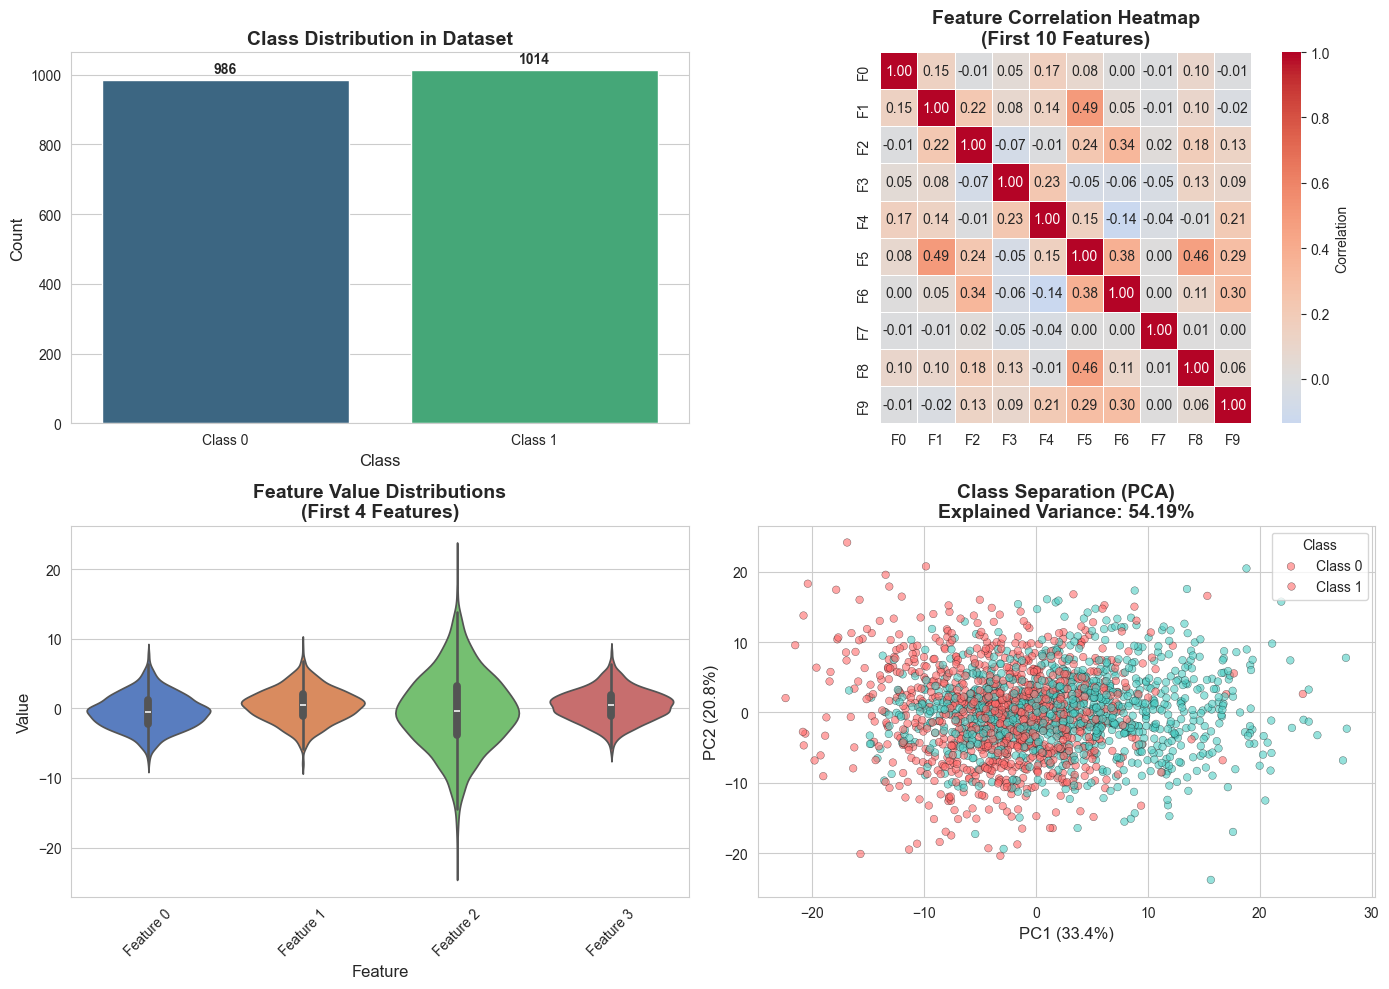

✓ Dataset visualization complete!
  - Total samples: 2000
  - Features: 20
  - Class balance: 986/1014 (Class 0/Class 1)


In [4]:
# ============================================================================
# DATA VISUALIZATION: Understanding the Dataset
# ============================================================================

# Set seaborn style for better-looking plots
sns.set_style("whitegrid")
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class Distribution
ax = axes[0, 0]
class_counts = pd.Series(y).value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, ax=ax, palette="viridis")
ax.set_title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['Class 0', 'Class 1'])
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 20, str(v), ha='center', fontweight='bold')

# 2. Feature Correlation Heatmap (first 10 features for readability)
ax = axes[0, 1]
feature_df = pd.DataFrame(X[:, :10], columns=[f'F{i}' for i in range(10)])
correlation_matrix = feature_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, cbar_kws={'label': 'Correlation'}, 
            square=True, linewidths=0.5)
ax.set_title('Feature Correlation Heatmap\n(First 10 Features)', fontsize=14, fontweight='bold')

# 3. Feature Distribution for First 4 Features
ax = axes[1, 0]
feature_data = pd.DataFrame({
    'Feature 0': X[:, 0],
    'Feature 1': X[:, 1],
    'Feature 2': X[:, 2],
    'Feature 3': X[:, 3],
})
feature_data_melted = feature_data.melt(var_name='Feature', value_name='Value')
sns.violinplot(data=feature_data_melted, x='Feature', y='Value', ax=ax, palette="muted")
ax.set_title('Feature Value Distributions\n(First 4 Features)', fontsize=14, fontweight='bold')
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# 4. Class Separation Visualization (using first 2 principal components)
ax = axes[1, 1]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
scatter_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Class': y
})
sns.scatterplot(data=scatter_df, x='PC1', y='PC2', hue='Class', 
                palette=['#FF6B6B', '#4ECDC4'], ax=ax, s=30, alpha=0.6, edgecolor='black', linewidth=0.3)
ax.set_title(f'Class Separation (PCA)\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}', 
             fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.legend(title='Class', labels=['Class 0', 'Class 1'])

plt.tight_layout()
plt.show()

print("✓ Dataset visualization complete!")
print(f"  - Total samples: {len(X)}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Class balance: {class_counts.values[0]}/{class_counts.values[1]} (Class 0/Class 1)")

In [5]:
# need to split data into 3 sets for unlearning:
# - retain set (what model should keep knowing)
# - forget set (what we want it to forget)
# - test set (for evaluation)

# first split off test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=42, 
    stratify=y  # keeping class balance
)

# now split training into retain and forget
# using 10% as forget set - seems like a reasonable amount
forget_ratio = 0.1
X_retain, X_forget, y_retain, y_forget = train_test_split(
    X_train, y_train, 
    test_size=forget_ratio,
    random_state=42, 
    stratify=y_train
)

print(f"\nData splits:")
print(f"Retain set: {X_retain.shape[0]} samples")
print(f"Forget set: {X_forget.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Data splits:
Retain set: 1440 samples
Forget set: 160 samples
Test set: 400 samples


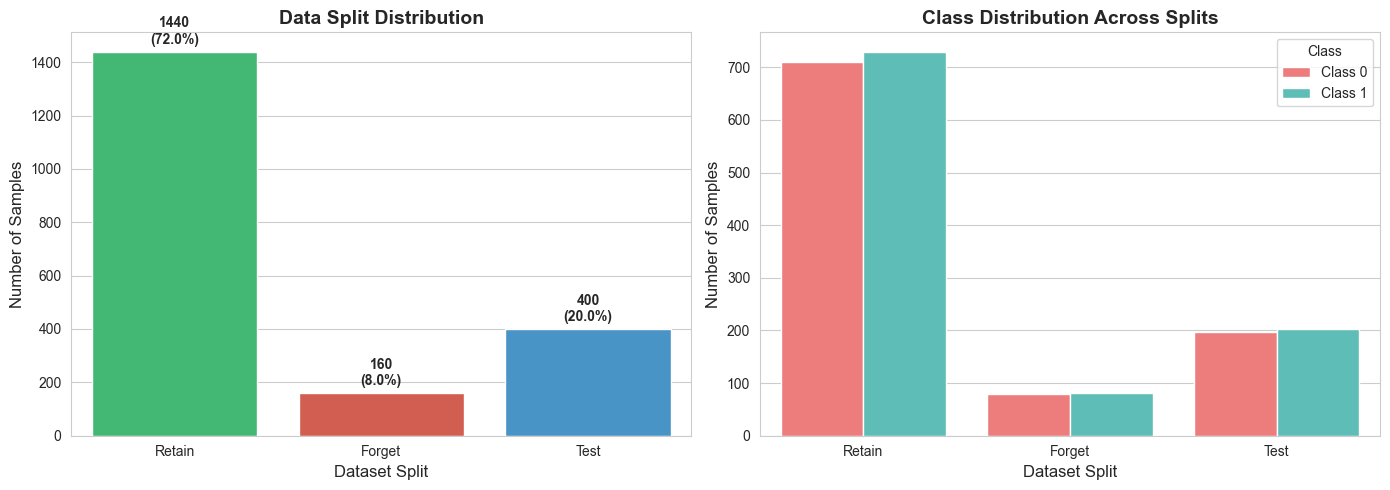

✓ Data split visualization complete!
  - Retain set: 1440 samples (72.0%)
  - Forget set: 160 samples (8.0%)
  - Test set: 400 samples (20.0%)


In [6]:
# ============================================================================
# VISUALIZE DATA SPLITS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Split Sizes
ax = axes[0]
split_data = pd.DataFrame({
    'Split': ['Retain', 'Forget', 'Test'],
    'Samples': [X_retain.shape[0], X_forget.shape[0], X_test.shape[0]],
    'Percentage': [
        X_retain.shape[0]/len(X)*100, 
        X_forget.shape[0]/len(X)*100, 
        X_test.shape[0]/len(X)*100
    ]
})
colors = ['#2ecc71', '#e74c3c', '#3498db']
bars = sns.barplot(data=split_data, x='Split', y='Samples', ax=ax, palette=colors)
ax.set_title('Data Split Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset Split', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)

# Add percentage labels on bars
for i, (idx, row) in enumerate(split_data.iterrows()):
    ax.text(i, row['Samples'] + 30, f"{row['Samples']}\n({row['Percentage']:.1f}%)", 
            ha='center', fontweight='bold', fontsize=10)

# 2. Class Distribution Across Splits
ax = axes[1]
split_class_data = pd.DataFrame({
    'Split': ['Retain']*2 + ['Forget']*2 + ['Test']*2,
    'Class': ['Class 0', 'Class 1']*3,
    'Count': [
        np.sum(y_retain == 0), np.sum(y_retain == 1),
        np.sum(y_forget == 0), np.sum(y_forget == 1),
        np.sum(y_test == 0), np.sum(y_test == 1)
    ]
})
sns.barplot(data=split_class_data, x='Split', y='Count', hue='Class', ax=ax, palette=['#FF6B6B', '#4ECDC4'])
ax.set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset Split', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.legend(title='Class')

plt.tight_layout()
plt.show()

print("✓ Data split visualization complete!")
print(f"  - Retain set: {X_retain.shape[0]} samples ({X_retain.shape[0]/len(X)*100:.1f}%)")
print(f"  - Forget set: {X_forget.shape[0]} samples ({X_forget.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

In [7]:
# standardizing features - neural nets work better with normalized inputs
scaler = StandardScaler()

# decision: fit scaler only on retain set
# this is the "ideal" scenario where forget set never existed
# in reality, scaler would've been fit on all training data originally
# but using retain-only is standard in research papers for cleaner comparison
# could also try fitting on all training data for more realistic scenario

ideal_scenario = False

if ideal_scenario: 
    X_retain_scaled = scaler.fit_transform(X_retain)
    X_forget_scaled = scaler.transform(X_forget)
    X_test_scaled = scaler.transform(X_test)
else: 
# alternative approach (more realistic):
    X_full_train = np.vstack([X_retain, X_forget])
    scaler.fit(X_full_train)
    X_retain_scaled = scaler.transform(X_retain)
    X_forget_scaled = scaler.transform(X_forget)
    X_test_scaled = scaler.transform(X_test)

# convert to pytorch tensors
X_retain_tensor = torch.FloatTensor(X_retain_scaled).to(device)
X_forget_tensor = torch.FloatTensor(X_forget_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

y_retain_tensor = torch.LongTensor(y_retain).to(device)
y_forget_tensor = torch.LongTensor(y_forget).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print("\nData preparation complete!")


Data preparation complete!


## 2. Define Neural Network Model


In [8]:
# ============================================================================
# CUSTOM NORMALIZATION LAYERS
# ============================================================================

class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization.
    
    Unlike LayerNorm, RMSNorm does NOT center the data (no mean subtraction).
    It only scales by the root mean square of the activations.
    
    Benefits:
    - More computationally efficient than LayerNorm (no mean computation)
    - Simpler gradient flow (fewer operations)
    - Used in modern architectures like LLaMA, GPT-3.5+, Gemma
    
    For machine unlearning: Fewer learned statistics may mean less "memory"
    of specific training examples.
    
    Formula: RMSNorm(x) = x / RMS(x) * gamma
             where RMS(x) = sqrt(mean(x^2) + eps)
    """
    def __init__(self, normalized_shape, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))  # learnable scale parameter
        
    def forward(self, x):
        # computing RMS
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        # normalize and scale
        return (x / rms) * self.weight


class InstanceNormForTabular(nn.Module):
    """
    Instance Normalization for 2D tabular data.
    
    PyTorch's InstanceNorm1d expects 3D input and >1 spatial elements,
    which doesn't work for tabular data (batch, features).
    
    This custom implementation normalizes each sample independently:
    - Computes mean and std across ALL features for each sample
    - Normalizes each sample to have mean=0, std=1
    - Applies learnable scale (gamma) and shift (beta) per feature
    
    Key difference from LayerNorm:
    - LayerNorm: normalizes and then applies shared gamma/beta
    - InstanceNorm: conceptually similar but designed for independence
    
    For tabular data, this is effectively equivalent to LayerNorm,
    but we keep it separate for experimental comparison.
    
    Formula: y = gamma * (x - mean(x)) / (std(x) + eps) + beta
    """
    def __init__(self, num_features, affine=True, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        
        if affine:
            # learnable scale and shift per feature
            self.weight = nn.Parameter(torch.ones(num_features))
            self.bias = nn.Parameter(torch.zeros(num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        
    def forward(self, x):
        # computing per-sample statistics
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=False)
        
        # normalizing
        x_normalized = (x - mean) / (std + self.eps)
        
        # applying learned scale/shift if enabled
        if self.affine:
            x_normalized = self.weight * x_normalized + self.bias
            
        return x_normalized


# ============================================================================
# NEURAL NETWORK MODEL DEFINITION (ENHANCED VERSION)
# ============================================================================

class TabularClassifier(nn.Module):
    """
    Deep neural network for binary classification on tabular data.
    
    Enhanced with multiple architectural options:
    - Different layer size patterns (funnel, constant, increasing, hourglass, etc.)
    - Multiple normalization options (BatchNorm, LayerNorm, InstanceNorm, GroupNorm, RMSNorm, none)
    - Multiple activation functions (ReLU, LeakyReLU, ELU, Tanh, GELU, Swish)
    - Dropout for regularization
    """
    
    def __init__(self, input_size, hidden_sizes=[64, 32, 16], num_classes=2, dropout=0.3,
                 normalization='batch', activation='relu', num_groups=4):
        """
        Initialize the neural network architecture.
        
        Args:
            input_size: Number of input features (20 in our case)
            hidden_sizes: List of hidden layer sizes or pattern name
            num_classes: Number of output classes (2 for binary classification)
            dropout: Dropout probability (0.3 = 30% of neurons randomly deactivated)
            normalization: Type of normalization to use
                - 'batch': BatchNorm1d (default, good for most cases)
                    → Normalizes across batch for each feature
                    → Learns running statistics during training
                    → Good for large batches, different train/eval behavior
                - 'layer': LayerNorm (more stable, good for small batches)
                    → Normalizes across features for each sample
                    → Batch-size independent, same train/eval behavior
                - 'instance': InstanceNorm1d (each sample normalized independently)
                    → Similar to LayerNorm but with different affine behavior
                    → Good when samples should be treated completely independently
                - 'group': GroupNorm (divides features into groups)
                    → Middle ground between Layer and Batch normalization
                    → Robust to batch size, good for varied architectures
                - 'rms': RMSNorm (Root Mean Square normalization)
                    → Simpler than LayerNorm (no mean centering)
                    → More efficient, used in modern LLMs (LLaMA, GPT-3.5+)
                    → Potentially less "memory" of specific training examples
                - 'none' or None: No normalization
            activation: Activation function to use
                - 'relu': ReLU (default, fast and effective)
                - 'leakyrelu': LeakyReLU (prevents dying neurons)
                - 'elu': ELU (smooth, can have negative values)
                - 'tanh': Tanh (classic, outputs in [-1, 1])
                - 'gelu': GELU (used in transformers, smooth approximation)
                - 'swish' or 'silu': Swish/SiLU (self-gated, smooth)
            num_groups: Number of groups for GroupNorm (default 4)
        """
        super(TabularClassifier, self).__init__()
        
        self.normalization = normalization
        self.activation = activation
        self.num_groups = num_groups
        
        layers = []  # Store all layers in a list
        prev_size = input_size  # Track input size for next layer
        
        # ========================================================================
        # BUILD HIDDEN LAYERS
        # ========================================================================
        for hidden_size in hidden_sizes:
            # 1. Linear (fully connected) layer
            layers.append(nn.Linear(prev_size, hidden_size))
            
            # 2. Normalization layer (optional)
            norm_layer = self._get_normalization(normalization, hidden_size)
            if norm_layer is not None:
                layers.append(norm_layer)
            
            # 3. Activation function
            layers.append(self._get_activation(activation))
            
            # 4. Dropout
            layers.append(nn.Dropout(dropout))
            
            prev_size = hidden_size
        
        # ========================================================================
        # OUTPUT LAYER
        # ========================================================================
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def _get_normalization(self, normalization, hidden_size):
        """Get normalization layer by name."""
        if normalization is None or normalization == 'none':
            return None
        
        normalization = normalization.lower()
        
        if normalization == 'batch':
            # BatchNorm: normalizes across batch for each feature
            # Stores running mean/var for inference
            return nn.BatchNorm1d(hidden_size)
        
        elif normalization == 'layer':
            # LayerNorm: normalizes across features for each sample
            # Batch-size independent
            return nn.LayerNorm(hidden_size)
        
        elif normalization == 'instance':
            # InstanceNorm: each sample normalized independently
            # Custom implementation for 2D tabular data
            # affine=True adds learnable scale and shift parameters
            return InstanceNormForTabular(hidden_size, affine=True)
        
        elif normalization == 'group':
            # GroupNorm: divides features into groups and normalizes within groups
            # Robust to batch size, good middle-ground
            # Ensure num_groups divides hidden_size evenly
            num_groups = min(self.num_groups, hidden_size)
            while hidden_size % num_groups != 0 and num_groups > 1:
                num_groups -= 1
            return nn.GroupNorm(num_groups, hidden_size)
        
        elif normalization == 'rms':
            # RMSNorm: simpler normalization without mean centering
            # More efficient, used in modern LLMs
            return RMSNorm(hidden_size)
        
        else:
            raise ValueError(f"Unknown normalization: {normalization}. "
                           f"Choose from: batch, layer, instance, group, rms, none")
        
    def _get_activation(self, activation):
        """Get activation function by name."""
        activation = activation.lower()
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'leakyrelu':
            return nn.LeakyReLU(0.1)
        elif activation == 'elu':
            return nn.ELU()
        elif activation == 'tanh':
            return nn.Tanh()
        elif activation == 'gelu':
            return nn.GELU()
        elif activation in ['swish', 'silu']:
            return nn.SiLU()
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
    def forward(self, x):
        """Forward pass: compute predictions from input."""
        return self.network(x)
    
    def get_layer_names(self):
        """Get names of linear layers for targeted noise injection."""
        return [name for name, module in self.named_modules() if isinstance(module, nn.Linear)]


# ============================================================================
# HELPER FUNCTION: GENERATE LAYER ARCHITECTURES
# ============================================================================

def generate_layer_architecture(input_size, pattern='funnel', num_layers=3, base_size=64):
    """
    Generate different layer size patterns for experimentation.
    
    Args:
        input_size: Number of input features
        pattern: Architecture pattern
            - 'funnel' or 'decreasing': Decreasing sizes (64 → 32 → 16)
            - 'constant': Same size (64 → 64 → 64)
            - 'increasing': Increasing sizes (16 → 32 → 64)
            - 'hourglass': Decrease then increase (64 → 32 → 64)
            - 'wide': Very wide layers (128 → 128 → 128)
            - 'deep_narrow': Many narrow layers (32 → 32 → 32 → 32 → 32)
            - 'adaptive': Scales with input size (input_size → input_size/2 → ...)
            - 'input_scaled': First layer matches input_size, then decreases
        num_layers: Number of hidden layers
        base_size: Base size for calculations
    
    Returns:
        List of layer sizes
    """
    if pattern in ['funnel', 'decreasing']:
        # Progressive decrease: good for compression
        return [base_size // (2**i) for i in range(num_layers)]
    
    elif pattern == 'constant':
        # Same size throughout: simpler architecture
        return [base_size] * num_layers
    
    elif pattern == 'increasing':
        # Progressive increase: expands representation
        return [base_size // (2**(num_layers-1-i)) for i in range(num_layers)]
    
    elif pattern == 'hourglass':
        # Compress then expand: bottleneck architecture
        sizes = []
        mid = num_layers // 2
        for i in range(num_layers):
            if i <= mid:
                sizes.append(base_size // (2**i))
            else:
                sizes.append(base_size // (2**(num_layers-1-i)))
        return sizes
    
    elif pattern == 'wide':
        # Wide layers: more capacity
        return [base_size * 2] * num_layers
    
    elif pattern == 'deep_narrow':
        # Many small layers: deep architecture
        return [base_size // 2] * (num_layers * 2)
    
    elif pattern == 'adaptive':
        # Adaptive pattern: scales with input size
        # Starts from input_size and progressively decreases
        # Good for datasets with many features
        return [max(8, input_size // (2**i)) for i in range(num_layers)]
    
    elif pattern == 'input_scaled':
        # First layer matches input size, then decreases
        # Ensures smooth transition from input to hidden layers
        sizes = [input_size]
        for i in range(1, num_layers):
            sizes.append(max(8, input_size // (2**i)))
        return sizes
    
    else:
        raise ValueError(f"Unknown pattern: {pattern}")


# ============================================================================
# TESTING FUNCTION: COMPARE ARCHITECTURES
# ============================================================================

def test_architecture_config(config_name, hidden_sizes, normalization='batch', 
                            activation='relu', dropout=0.3, epochs=50, verbose=False):
    """
    Test a specific architecture configuration.
    
    Args:
        config_name: Name for this configuration
        hidden_sizes: List of hidden layer sizes
        normalization: Normalization type
        activation: Activation function
        dropout: Dropout rate
        epochs: Number of training epochs
        verbose: Print training progress
    
    Returns:
        Dictionary with results
    """
    # Create model
    test_model = TabularClassifier(
        input_size=n_features,
        hidden_sizes=hidden_sizes,
        num_classes=2,
        dropout=dropout,
        normalization=normalization,
        activation=activation
    ).to(device)
    
    # Train on full training set
    X_full_train = torch.cat([X_retain_tensor, X_forget_tensor], dim=0)
    y_full_train = torch.cat([y_retain_tensor, y_forget_tensor], dim=0)
    
    _ = train_model(test_model, X_full_train, y_full_train, epochs=epochs, lr=0.001, verbose=verbose)
    
    # Evaluate
    retain_acc = evaluate_model(test_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(test_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(test_model, X_test_tensor, y_test_tensor)
    
    # Count parameters
    total_params = sum(p.numel() for p in test_model.parameters())
    
    return {
        'config': config_name,
        'hidden_sizes': hidden_sizes,
        'normalization': normalization,
        'activation': activation,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'total_params': total_params
    }

# creating the model
# went with funnel architecture: 64 -> 32 -> 16
# - first layer extracts basic patterns
# - middle layer combines them
# - last layer creates high-level features
model = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3  # using 30% dropout
).to(device)

print("Model Architecture:")
print(model)

# counting parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Model Architecture:
TabularClassifier(
  (network): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)

Total parameters: 4210
Trainable parameters: 4210


  DEMONSTRATING ADAPTIVE ARCHITECTURE PATTERNS

Input size: 20 features

1. Adaptive Pattern (scales with input size):
   Generated layers: [20, 10, 8]
   Architecture: 20 → 20 → 10 → 8 → 2

2. Input-Scaled Pattern (first layer matches input):
   Generated layers: [20, 10, 8]
   Architecture: 20 → 20 → 10 → 8 → 2

3. Traditional Funnel Pattern (for comparison):
   Generated layers: [64, 32, 16]
   Architecture: 20 → 64 → 32 → 16 → 2


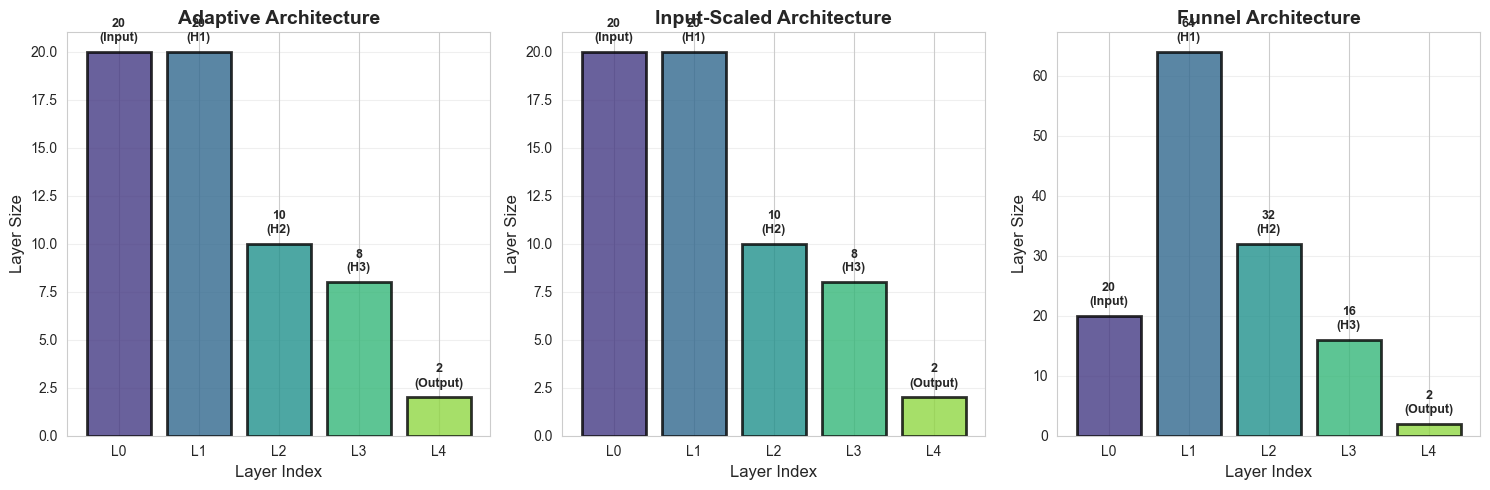


4. Parameter Comparison:
   Adaptive       : 736 parameters
   Input-Scaled   : 736 parameters
   Funnel         : 3,986 parameters


In [9]:
# ============================================================================
# DEMONSTRATION: New Adaptive Architecture Patterns
# ============================================================================

print("=" * 70)
print("  DEMONSTRATING ADAPTIVE ARCHITECTURE PATTERNS")
print("=" * 70)
print(f"\nInput size: {n_features} features\n")

# Test the new adaptive patterns that use input_size
print("1. Adaptive Pattern (scales with input size):")
adaptive_layers = generate_layer_architecture(n_features, pattern='adaptive', num_layers=3)
print(f"   Generated layers: {adaptive_layers}")
print(f"   Architecture: {n_features} → {' → '.join(map(str, adaptive_layers))} → 2")

print("\n2. Input-Scaled Pattern (first layer matches input):")
input_scaled_layers = generate_layer_architecture(n_features, pattern='input_scaled', num_layers=3)
print(f"   Generated layers: {input_scaled_layers}")
print(f"   Architecture: {n_features} → {' → '.join(map(str, input_scaled_layers))} → 2")

# Compare with traditional patterns
print("\n3. Traditional Funnel Pattern (for comparison):")
funnel_layers = generate_layer_architecture(n_features, pattern='funnel', num_layers=3, base_size=64)
print(f"   Generated layers: {funnel_layers}")
print(f"   Architecture: {n_features} → {' → '.join(map(str, funnel_layers))} → 2")

# Visualize the different architectures
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

patterns = [
    ('Adaptive', adaptive_layers),
    ('Input-Scaled', input_scaled_layers),
    ('Funnel', funnel_layers)
]

for idx, (name, layers) in enumerate(patterns):
    ax = axes[idx]
    
    # Create architecture visualization
    all_layers = [n_features] + layers + [2]
    x_pos = list(range(len(all_layers)))
    
    # Plot as bar chart
    colors = sns.color_palette("viridis", len(all_layers))
    bars = ax.bar(x_pos, all_layers, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
    
    # Add value labels
    for i, (x, y) in enumerate(zip(x_pos, all_layers)):
        label = 'Input' if i == 0 else ('Output' if i == len(all_layers)-1 else f'H{i}')
        ax.text(x, y + max(all_layers)*0.02, f'{y}\n({label})', 
               ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_title(f'{name} Architecture', fontsize=14, fontweight='bold')
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_ylabel('Layer Size', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'L{i}' for i in range(len(all_layers))])
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate total parameters for each architecture
def count_params(input_size, hidden_layers, output_size=2):
    total = 0
    prev = input_size
    for h in hidden_layers:
        total += prev * h + h  # weights + biases
        prev = h
    total += prev * output_size + output_size  # output layer
    return total

print("\n4. Parameter Comparison:")
for name, layers in patterns:
    params = count_params(n_features, layers)
    print(f"   {name:15s}: {params:,} parameters")


In [10]:
# ============================================================================
# ENHANCED EVALUATION FUNCTIONS WITH DETAILED METRICS
# ============================================================================

def evaluate_model_detailed(model, X, y, dataset_name="Dataset"):
    """
    Evaluate model with detailed metrics including classification report.
    
    Args:
        model: Trained neural network
        X: Features to evaluate on
        y: True labels
        dataset_name: Name of the dataset for display
    
    Returns:
        dict: Dictionary containing accuracy, predictions, and classification report
    """
    
    model.eval()
    
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        
        # Convert to numpy for sklearn
        y_true = y.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        
        accuracy = 100 * (y_pred == y_true).sum() / len(y_true)
        
        # Generate classification report
        report = classification_report(y_true, y_pred, 
                                       target_names=['Class 0', 'Class 1'],
                                       output_dict=True)
        
        print(f"\n{'='*60}")
        print(f"  {dataset_name} Evaluation Results")
        print(f"{'='*60}")
        print(f"Accuracy: {accuracy:.2f}%\n")
        print(classification_report(y_true, y_pred, 
                                   target_names=['Class 0', 'Class 1']))
        
        return {
            'accuracy': accuracy,
            'predictions': y_pred,
            'true_labels': y_true,
            'report': report
        }

def plot_confusion_matrix(model, X, y, title="Confusion Matrix"):
    """
    Plot confusion matrix using seaborn for better visualization.
    
    Args:
        model: Trained neural network
        X: Features to evaluate on
        y: True labels
        title: Title for the plot
    """
    from sklearn.metrics import confusion_matrix
    
    model.eval()
    
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        
        # Convert to numpy
        y_true = y.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Class 0', 'Class 1'],
                   yticklabels=['Class 0', 'Class 1'],
                   cbar_kws={'label': 'Count'},
                   square=True, linewidths=1, linecolor='black')
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # Add accuracy text
        accuracy = 100 * (y_pred == y_true).sum() / len(y_true)
        plt.text(1, -0.3, f'Accuracy: {accuracy:.2f}%', 
                ha='center', fontsize=11, fontweight='bold',
                transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()
        
        return cm

def compare_models_visualization(results_dict, title="Model Comparison"):
    """
    Create comprehensive visualization comparing multiple models.
    
    Args:
        results_dict: Dictionary with model names as keys and 
                     (retain_acc, forget_acc, test_acc) tuples as values
        title: Title for the plot
    """
    models = list(results_dict.keys())
    retain_accs = [results_dict[m][0] for m in models]
    forget_accs = [results_dict[m][1] for m in models]
    test_accs = [results_dict[m][2] for m in models]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Grouped bar chart
    ax = axes[0]
    x = np.arange(len(models))
    width = 0.25
    
    bars1 = ax.bar(x - width, retain_accs, width, label='Retain Acc', 
                   color='#2ecc71', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x, forget_accs, width, label='Forget Acc', 
                   color='#e74c3c', alpha=0.8, edgecolor='black')
    bars3 = ax.bar(x + width, test_accs, width, label='Test Acc', 
                   color='#3498db', alpha=0.8, edgecolor='black')
    
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 105])
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=8)
    
    # 2. Heatmap
    ax = axes[1]
    data_matrix = np.array([retain_accs, forget_accs, test_accs])
    sns.heatmap(data_matrix, annot=True, fmt='.1f', cmap='RdYlGn',
               xticklabels=models, 
               yticklabels=['Retain', 'Forget', 'Test'],
               cbar_kws={'label': 'Accuracy (%)'},
               ax=ax, vmin=0, vmax=100, linewidths=1, linecolor='black')
    ax.set_title('Accuracy Heatmap', fontsize=14, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

print("✓ Enhanced evaluation functions with classification_report and confusion matrix added!")

✓ Enhanced evaluation functions with classification_report and confusion matrix added!


## 3. Training and Evaluation Functions


In [11]:
# ============================================================================
# TRAINING AND EVALUATION UTILITY FUNCTIONS
# ============================================================================

def train_model(model, X_train, y_train, epochs=50, batch_size=32, lr=0.001, verbose=True):
    """
    Train the neural network using standard supervised learning.
    
    Args:
        model: The neural network to train
        X_train: Training features (tensor)
        y_train: Training labels (tensor)
        epochs: Number of complete passes through the dataset
                - More epochs = more learning but risk of overfitting
                - We use 50-100 epochs as a good balance
        batch_size: Number of samples processed before updating weights
                    - Smaller batches (16-32): More noise, better generalization, slower
                    - Larger batches (128-256): More stable, faster, may overfit
                    - 32 is a good default for small-medium datasets
        lr: Learning rate for Adam optimizer
            - Too high (>0.01): Training may diverge (loss explodes)
            - Too low (<0.0001): Training too slow, may get stuck
            - 0.001 is a safe default for Adam
        verbose: Whether to print training progress
    
    Returns:
        losses: List of average loss per epoch (for plotting convergence)
    """
    model.train()  # Set model to training mode (enables dropout and batch norm updates)
    
    # ========================================================================
    # LOSS FUNCTION
    # ========================================================================
    # CrossEntropyLoss combines log_softmax and negative log likelihood
    # It's the standard loss for multi-class classification
    # For binary classification, it automatically handles both classes
    criterion = nn.CrossEntropyLoss()
    
    # using Adam - works well without much tuning
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # setting up data loader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True  # shuffling each epoch
    )
    
    losses = []  # Track loss over time to monitor convergence
    
    # ========================================================================
    # TRAINING LOOP
    # ========================================================================
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # training loop
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(batch_X)
            
            # compute loss
            loss = criterion(outputs, batch_y)
            
            # backward pass
            loss.backward()
            
            # update weights
            optimizer.step()
            
            epoch_loss += loss.item()  # Accumulate loss for this epoch
        
        # Calculate average loss across all batches
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Print progress every 10 epochs
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return losses

def evaluate_model(model, X, y):
    """
    Evaluate model accuracy on a dataset.
    
    This is used to measure:
    - Retain set accuracy: How well model remembers retained data
    - Forget set accuracy: How well model remembers forgotten data (should decrease after unlearning)
    - Test set accuracy: Overall model performance on unseen data
    
    Args:
        model: Trained neural network
        X: Features to evaluate on
        y: True labels
    
    Returns:
        accuracy: Percentage of correctly classified samples (0-100)
    """
    model.eval()  # evaluation mode
    
    with torch.no_grad():
        # getting predictions
        outputs = model(X)
        
        # taking argmax for predicted class
        # outputs.data contains raw logits for each class
        # torch.max returns (max_values, indices) - we only need indices
        _, predicted = torch.max(outputs.data, 1)  # 1 means take max along class dimension
        
        # Calculate accuracy
        correct = (predicted == y).sum().item()  # Count correct predictions
        total = y.size(0)  # Total number of samples
        accuracy = 100 * correct / total
    
    return accuracy

def get_model_state_dict_copy(model):
    """
    Create a deep copy of model's parameters (weights and biases).
    
    Why do we need this?
    - To save original model state before applying unlearning
    - To compare how much parameters changed after unlearning
    - .clone().detach() creates independent copy (changes won't affect original)
    
    Args:
        model: PyTorch model
    
    Returns:
        Dictionary mapping parameter names to their cloned tensors
    """
    return {name: param.clone().detach() for name, param in model.state_dict().items()}

def calculate_parameter_distance(state_dict1, state_dict2):
    """
    Calculate L2 (Euclidean) distance between two sets of model parameters.
    
    This metric tells us:
    - How much the model changed after unlearning
    - Larger distance = more aggressive unlearning
    - Can help find optimal noise level (balance between forgetting and retaining)
    
    The L2 distance is computed as:
    distance = sqrt(sum((param1 - param2)^2))
    
    We only consider weights and biases (not batch norm statistics).
    
    Args:
        state_dict1: First model's parameters (e.g., original model)
        state_dict2: Second model's parameters (e.g., after unlearning)
    
    Returns:
        distance: Scalar value representing total parameter change
    """
    distance = 0.0
    
    # Iterate through all parameters
    for key in state_dict1.keys():
        # Only compare weights and biases (skip batch norm running stats)
        if 'weight' in key or 'bias' in key:
            # Compute squared difference for this parameter
            param_diff = state_dict1[key] - state_dict2[key]
            # Add squared norm to total distance
            distance += torch.norm(param_diff).item() ** 2
    
    # Return square root of sum of squared differences (L2 norm)
    return np.sqrt(distance)

print("Training and evaluation functions defined!")


Training and evaluation functions defined!


### 2.1 Architecture Experimentation

Now let's experiment with different architecture configurations to see what works best for our data!


In [ ]:
# ============================================================================
# EXPERIMENT 1: COMPARE DIFFERENT LAYER ARCHITECTURES
# ============================================================================
print("=" * 80)
print("EXPERIMENT 1: Testing Different Layer Architecture Patterns")
print("=" * 80)

# Test different architecture patterns
architecture_results = []

patterns = ['funnel', 'constant', 'increasing', 'hourglass']
for pattern in patterns:
    print(f"\nTesting {pattern} architecture...")
    hidden_sizes = generate_layer_architecture(n_features, pattern=pattern, num_layers=3, base_size=64)
    print(f"  Layer sizes: {hidden_sizes}")
    
    result = test_architecture_config(
        config_name=f"{pattern.capitalize()} ({hidden_sizes})",
        hidden_sizes=hidden_sizes,
        normalization='batch',
        activation='relu',
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    architecture_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%, Params={result['total_params']}")

# Display results
arch_df = pd.DataFrame(architecture_results)
print("\n" + "=" * 80)
print("Architecture Pattern Results:")
print("=" * 80)
print(arch_df[['config', 'retain_acc', 'forget_acc', 'test_acc', 'total_params']].to_string(index=False))
print("=" * 80)


# ============================================================================
# EXPERIMENT 2: COMPARE DIFFERENT NORMALIZATION METHODS
# ============================================================================
print("\n\n" + "=" * 80)
print("EXPERIMENT 2: Testing Different Normalization Methods")
print("=" * 80)
print("""
Normalization types tested:
- batch: BatchNorm1d - normalizes across batch for each feature
- layer: LayerNorm - normalizes across features for each sample
- instance: InstanceNorm1d - each sample normalized independently
- group: GroupNorm - divides features into groups and normalizes within groups
- rms: RMSNorm - simpler normalization without mean centering (used in LLaMA, GPT-3.5+)
- none: No normalization
""")

normalization_results = []
norm_types = ['batch', 'layer', 'instance', 'group', 'rms', 'none']

for norm in norm_types:
    print(f"\nTesting {norm} normalization...")
    
    result = test_architecture_config(
        config_name=f"Norm: {norm}",
        hidden_sizes=[64, 32, 16],
        normalization=norm,
        activation='relu',
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    normalization_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%")

# Display results
norm_df = pd.DataFrame(normalization_results)
print("\n" + "=" * 80)
print("Normalization Method Results:")
print("=" * 80)
print(norm_df[['config', 'retain_acc', 'forget_acc', 'test_acc']].to_string(index=False))
print("=" * 80)


# ============================================================================
# EXPERIMENT 3: COMPARE DIFFERENT ACTIVATION FUNCTIONS
# ============================================================================
print("\n\n" + "=" * 80)
print("EXPERIMENT 3: Testing Different Activation Functions")
print("=" * 80)

activation_results = []
activations = ['relu', 'leakyrelu', 'elu', 'tanh', 'gelu', 'swish']

for act in activations:
    print(f"\nTesting {act} activation...")
    
    result = test_architecture_config(
        config_name=f"Act: {act}",
        hidden_sizes=[64, 32, 16],
        normalization='batch',
        activation=act,
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    activation_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%")

# Display results
act_df = pd.DataFrame(activation_results)
print("\n" + "=" * 80)
print("Activation Function Results:")
print("=" * 80)
print(act_df[['config', 'retain_acc', 'forget_acc', 'test_acc']].to_string(index=False))
print("=" * 80)


# ============================================================================
# EXPERIMENT 4: VISUALIZE COMPARISONS
# ============================================================================
print("\n\nGenerating comparison visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Architecture Configuration Comparison', fontsize=16, fontweight='bold')

# 1. Architecture patterns
ax = axes[0]
x_pos = np.arange(len(arch_df))
width = 0.25
ax.bar(x_pos - width, arch_df['retain_acc'], width, label='Retain', alpha=0.8)
ax.bar(x_pos, arch_df['forget_acc'], width, label='Forget', alpha=0.8)
ax.bar(x_pos + width, arch_df['test_acc'], width, label='Test', alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Layer Architecture Patterns', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels([p.split()[0] for p in patterns], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Normalization methods
ax = axes[1]
x_pos = np.arange(len(norm_df))
ax.bar(x_pos - width, norm_df['retain_acc'], width, label='Retain', alpha=0.8)
ax.bar(x_pos, norm_df['forget_acc'], width, label='Forget', alpha=0.8)
ax.bar(x_pos + width, norm_df['test_acc'], width, label='Test', alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Normalization Methods', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(norm_types, rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Activation functions
ax = axes[2]
x_pos = np.arange(len(act_df))
ax.bar(x_pos - width, act_df['retain_acc'], width, label='Retain', alpha=0.8)
ax.bar(x_pos, act_df['forget_acc'], width, label='Forget', alpha=0.8)
ax.bar(x_pos + width, act_df['test_acc'], width, label='Test', alpha=0.8)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Activation Functions', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(activations, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# ============================================================================
# EXPERIMENT 5: CUSTOM COMBINATIONS
# ============================================================================
print("\n\n" + "=" * 80)
print("EXPERIMENT 5: Testing Custom Combinations")
print("=" * 80)
print("Now testing some promising combinations based on results above...")

# Test a few custom combinations
custom_configs = [
    {'name': 'Best Overall', 'arch': 'funnel', 'norm': 'batch', 'act': 'relu'},
    {'name': 'Alternative 1', 'arch': 'constant', 'norm': 'layer', 'act': 'leakyrelu'},
    {'name': 'Alternative 2', 'arch': 'hourglass', 'norm': 'batch', 'act': 'gelu'},
    {'name': 'No Norm', 'arch': 'funnel', 'norm': 'none', 'act': 'elu'},
]

custom_results = []

for config in custom_configs:
    print(f"\nTesting {config['name']}: arch={config['arch']}, norm={config['norm']}, act={config['act']}")
    hidden_sizes = generate_layer_architecture(n_features, pattern=config['arch'], num_layers=3, base_size=64)
    
    result = test_architecture_config(
        config_name=config['name'],
        hidden_sizes=hidden_sizes,
        normalization=config['norm'],
        activation=config['act'],
        dropout=0.3,
        epochs=50,
        verbose=False
    )
    custom_results.append(result)
    print(f"  Results: Retain={result['retain_acc']:.2f}%, Forget={result['forget_acc']:.2f}%, Test={result['test_acc']:.2f}%")

# Display results
custom_df = pd.DataFrame(custom_results)
print("\n" + "=" * 80)
print("Custom Combination Results:")
print("=" * 80)
print(custom_df[['config', 'normalization', 'activation', 'retain_acc', 'forget_acc', 'test_acc']].to_string(index=False))
print("=" * 80)

print("\n✅ Architecture experimentation complete!")
print("💡 Use these results to choose the best configuration for your unlearning experiments.")


EXPERIMENT 1: Testing Different Layer Architecture Patterns

Testing funnel architecture...
  Layer sizes: [64, 32, 16]


### Quick Reference: How to Create Custom Architectures

Here are some quick examples for creating your own custom model configurations:


In [ ]:
# ============================================================================
# QUICK EXAMPLES: Creating Custom Architectures
# ============================================================================

print("=" * 80)
print("QUICK REFERENCE: Custom Architecture Examples")
print("=" * 80)

# Example 1: Basic model with different activation
print("\n1. Model with LeakyReLU activation:")
model_leaky = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='leakyrelu'  # Just change this!
)
print(f"   Created model with {sum(p.numel() for p in model_leaky.parameters())} parameters")

# Example 2: Model with LayerNorm instead of BatchNorm
print("\n2. Model with LayerNorm:")
model_ln = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3,
    normalization='layer',  # Change normalization
    activation='relu'
)
print(f"   Created model with {sum(p.numel() for p in model_ln.parameters())} parameters")

# Example 3: Model with no normalization
print("\n3. Model with no normalization:")
model_no_norm = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],
    num_classes=2,
    dropout=0.3,
    normalization='none',  # No normalization
    activation='relu'
)
print(f"   Created model with {sum(p.numel() for p in model_no_norm.parameters())} parameters")

# Example 4: Using architecture patterns
print("\n4. Model with constant layer sizes:")
constant_layers = generate_layer_architecture(n_features, pattern='constant', num_layers=3, base_size=64)
print(f"   Generated layers: {constant_layers}")
model_constant = TabularClassifier(
    input_size=n_features,
    hidden_sizes=constant_layers,
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='relu'
)
print(f"   Created model with {sum(p.numel() for p in model_constant.parameters())} parameters")

# Example 5: Hourglass architecture with GELU activation
print("\n5. Hourglass architecture with GELU:")
hourglass_layers = generate_layer_architecture(n_features, pattern='hourglass', num_layers=4, base_size=64)
print(f"   Generated layers: {hourglass_layers}")
model_hourglass = TabularClassifier(
    input_size=n_features,
    hidden_sizes=hourglass_layers,
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='gelu'
)
print(f"   Created model with {sum(p.numel() for p in model_hourglass.parameters())} parameters")

# Example 6: Wide network with Swish activation
print("\n6. Wide network with Swish activation:")
wide_layers = generate_layer_architecture(n_features, pattern='wide', num_layers=3, base_size=64)
print(f"   Generated layers: {wide_layers}")
model_wide = TabularClassifier(
    input_size=n_features,
    hidden_sizes=wide_layers,
    num_classes=2,
    dropout=0.2,  # Lower dropout for wider network
    normalization='batch',
    activation='swish'
)
print(f"   Created model with {sum(p.numel() for p in model_wide.parameters())} parameters")

# Example 7: Deep narrow network with ELU
print("\n7. Deep narrow network with ELU:")
deep_layers = generate_layer_architecture(n_features, pattern='deep_narrow', num_layers=3, base_size=64)
print(f"   Generated layers: {deep_layers}")
model_deep = TabularClassifier(
    input_size=n_features,
    hidden_sizes=deep_layers,
    num_classes=2,
    dropout=0.4,  # Higher dropout for deeper network
    normalization='batch',
    activation='elu'
)
print(f"   Created model with {sum(p.numel() for p in model_deep.parameters())} parameters")

# Example 8: Custom layer sizes with your own list
print("\n8. Custom layer sizes (manual):")
custom_layers = [128, 64, 32, 16, 8]  # Your own sizes!
model_custom = TabularClassifier(
    input_size=n_features,
    hidden_sizes=custom_layers,
    num_classes=2,
    dropout=0.3,
    normalization='batch',
    activation='relu'
)
print(f"   Custom layers: {custom_layers}")
print(f"   Created model with {sum(p.numel() for p in model_custom.parameters())} parameters")

print("\n" + "=" * 80)
print("\n💡 SUMMARY OF OPTIONS:")
print("\nArchitecture Patterns (use with generate_layer_architecture):")
print("  • 'funnel' or 'decreasing': [64, 32, 16] - Good for compression")
print("  • 'constant': [64, 64, 64] - Simpler, consistent capacity")
print("  • 'increasing': [16, 32, 64] - Expands representation")
print("  • 'hourglass': [64, 32, 16, 32, 64] - Bottleneck in middle")
print("  • 'wide': [128, 128, 128] - More capacity")
print("  • 'deep_narrow': [32, 32, 32, 32, 32, 32] - Many small layers")

print("\nNormalization Options:")
print("  • 'batch': BatchNorm1d (default, good for most cases)")
print("  • 'layer': LayerNorm (more stable, good for small batches)")
print("  • 'instance': InstanceNorm1d (each sample normalized independently)")
print("  • 'group': GroupNorm (divides features into groups, robust to batch size)")
print("  • 'rms': RMSNorm (no mean centering, efficient, used in LLaMA/GPT)")
print("  • 'none': No normalization")

print("\nActivation Functions:")
print("  • 'relu': Fast, standard choice")
print("  • 'leakyrelu': Prevents dying neurons")
print("  • 'elu': Smooth, can be negative")
print("  • 'tanh': Classic, bounded [-1, 1]")
print("  • 'gelu': Modern, used in transformers")
print("  • 'swish'/'silu': Self-gated, smooth")

print("\n" + "=" * 80)
print("✅ You can now mix and match any combination!")


QUICK REFERENCE: Custom Architecture Examples

1. Model with LeakyReLU activation:
   Created model with 4210 parameters

2. Model with LayerNorm:
   Created model with 4210 parameters

3. Model with no normalization:
   Created model with 3986 parameters

4. Model with constant layer sizes:
   Generated layers: [64, 64, 64]
   Created model with 10178 parameters

5. Hourglass architecture with GELU:
   Generated layers: [64, 32, 16, 64]
   Created model with 5522 parameters

6. Wide network with Swish activation:
   Generated layers: [128, 128, 128]
   Created model with 36738 parameters

7. Deep narrow network with ELU:
   Generated layers: [32, 32, 32, 32, 32, 32]
   Created model with 6402 parameters

8. Custom layer sizes (manual):
   Custom layers: [128, 64, 32, 16, 8]
   Created model with 14202 parameters


💡 SUMMARY OF OPTIONS:

Architecture Patterns (use with generate_layer_architecture):
  • 'funnel' or 'decreasing': [64, 32, 16] - Good for compression
  • 'constant': [64, 6

### Testing Your Own Configuration

Want to quickly test your own custom configuration? Use this template:


In [ ]:
# ============================================================================
# TEMPLATE: Test Your Own Configuration
# ============================================================================
# Modify the parameters below to test your own custom architecture!

# 🔧 CUSTOMIZE THESE PARAMETERS:
MY_ARCHITECTURE = 'funnel'  # Options: 'funnel', 'constant', 'increasing', 'hourglass', 'wide', 'deep_narrow'
MY_NORMALIZATION = 'batch'  # Options: 'batch', 'layer', 'none'
MY_ACTIVATION = 'relu'      # Options: 'relu', 'leakyrelu', 'elu', 'tanh', 'gelu', 'swish'
MY_DROPOUT = 0.3           # Range: 0.0 to 0.5 (higher = more regularization)
MY_NUM_LAYERS = 3          # Number of hidden layers
MY_BASE_SIZE = 64          # Base size for layer generation

# Or specify custom layer sizes directly (uncomment to use):
# MY_CUSTOM_LAYERS = [128, 64, 32, 16]  # Your custom sizes

# ============================================================================

print("Testing your custom configuration...")
print("=" * 80)

# Generate layer sizes (or use custom ones)
if 'MY_CUSTOM_LAYERS' in locals():
    my_layers = MY_CUSTOM_LAYERS
    print(f"Using custom layers: {my_layers}")
else:
    my_layers = generate_layer_architecture(n_features, pattern=MY_ARCHITECTURE, 
                                           num_layers=MY_NUM_LAYERS, base_size=MY_BASE_SIZE)
    print(f"Generated {MY_ARCHITECTURE} architecture: {my_layers}")

# Test the configuration
my_result = test_architecture_config(
    config_name=f"My Config",
    hidden_sizes=my_layers,
    normalization=MY_NORMALIZATION,
    activation=MY_ACTIVATION,
    dropout=MY_DROPOUT,
    epochs=50,  # Change if you want faster/slower training
    verbose=False
)

print("\n" + "=" * 80)
print("YOUR CONFIGURATION RESULTS:")
print("=" * 80)
print(f"Architecture Pattern: {MY_ARCHITECTURE}")
print(f"Layer Sizes: {my_layers}")
print(f"Normalization: {MY_NORMALIZATION}")
print(f"Activation: {MY_ACTIVATION}")
print(f"Dropout: {MY_DROPOUT}")
print(f"\nRetain Set Accuracy: {my_result['retain_acc']:.2f}%")
print(f"Forget Set Accuracy: {my_result['forget_acc']:.2f}%")
print(f"Test Set Accuracy: {my_result['test_acc']:.2f}%")
print(f"Total Parameters: {my_result['total_params']:,}")
print("=" * 80)

# Optional: Compare with baseline (original funnel architecture)
baseline_result = test_architecture_config(
    config_name="Baseline",
    hidden_sizes=[64, 32, 16],
    normalization='batch',
    activation='relu',
    dropout=0.3,
    epochs=50,
    verbose=False
)

print("\nCOMPARISON WITH BASELINE:")
print("=" * 80)
print(f"{'Metric':<25} | {'Your Config':>15} | {'Baseline':>15} | {'Difference':>15}")
print("-" * 80)
print(f"{'Retain Accuracy':<25} | {my_result['retain_acc']:>14.2f}% | {baseline_result['retain_acc']:>14.2f}% | {my_result['retain_acc']-baseline_result['retain_acc']:>+14.2f}%")
print(f"{'Forget Accuracy':<25} | {my_result['forget_acc']:>14.2f}% | {baseline_result['forget_acc']:>14.2f}% | {my_result['forget_acc']-baseline_result['forget_acc']:>+14.2f}%")
print(f"{'Test Accuracy':<25} | {my_result['test_acc']:>14.2f}% | {baseline_result['test_acc']:>14.2f}% | {my_result['test_acc']-baseline_result['test_acc']:>+14.2f}%")
print(f"{'Parameters':<25} | {my_result['total_params']:>15,} | {baseline_result['total_params']:>15,} | {my_result['total_params']-baseline_result['total_params']:>+15,}")
print("=" * 80)

if my_result['test_acc'] > baseline_result['test_acc']:
    print("\n🎉 Your configuration outperforms the baseline!")
elif my_result['test_acc'] == baseline_result['test_acc']:
    print("\n✅ Your configuration matches the baseline performance.")
else:
    print("\n💡 Baseline performs better. Try adjusting your parameters!")

print("\n💡 TIP: Modify the parameters at the top of this cell and run again to experiment!")


Testing your custom configuration...
Generated funnel architecture: [64, 32, 16]

YOUR CONFIGURATION RESULTS:
Architecture Pattern: funnel
Layer Sizes: [64, 32, 16]
Normalization: batch
Activation: relu
Dropout: 0.3

Retain Set Accuracy: 94.93%
Forget Set Accuracy: 93.75%
Test Set Accuracy: 90.00%
Total Parameters: 4,210

COMPARISON WITH BASELINE:
Metric                    |     Your Config |        Baseline |      Difference
--------------------------------------------------------------------------------
Retain Accuracy           |          94.93% |          95.14% |          -0.21%
Forget Accuracy           |          93.75% |          93.75% |          +0.00%
Test Accuracy             |          90.00% |          88.75% |          +1.25%
Parameters                |           4,210 |           4,210 |              +0

🎉 Your configuration outperforms the baseline!

💡 TIP: Modify the parameters at the top of this cell and run again to experiment!


## 4. Train Original Model


Training original model on full training set...
Epoch [10/500], Loss: 0.3547
Epoch [20/500], Loss: 0.3082
Epoch [30/500], Loss: 0.2876
Epoch [40/500], Loss: 0.2534
Epoch [50/500], Loss: 0.2759
Epoch [60/500], Loss: 0.2410
Epoch [70/500], Loss: 0.2315
Epoch [80/500], Loss: 0.2535
Epoch [90/500], Loss: 0.2482
Epoch [100/500], Loss: 0.2302
Epoch [110/500], Loss: 0.2486
Epoch [120/500], Loss: 0.2215
Epoch [130/500], Loss: 0.2096
Epoch [140/500], Loss: 0.1992
Epoch [150/500], Loss: 0.2297
Epoch [160/500], Loss: 0.2157
Epoch [170/500], Loss: 0.2282
Epoch [180/500], Loss: 0.2078
Epoch [190/500], Loss: 0.2015
Epoch [200/500], Loss: 0.2035
Epoch [210/500], Loss: 0.2131
Epoch [220/500], Loss: 0.1955
Epoch [230/500], Loss: 0.2180
Epoch [240/500], Loss: 0.1944
Epoch [250/500], Loss: 0.2037
Epoch [260/500], Loss: 0.2062
Epoch [270/500], Loss: 0.1977
Epoch [280/500], Loss: 0.2067
Epoch [290/500], Loss: 0.1884
Epoch [300/500], Loss: 0.1823
Epoch [310/500], Loss: 0.1796
Epoch [320/500], Loss: 0.1773
E

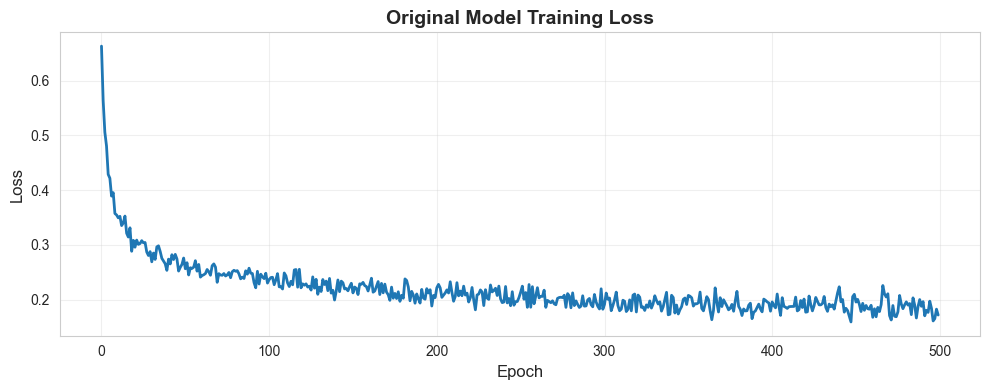

In [ ]:
# training the original model on all data
# combining retain and forget sets - simulating real scenario where
# model was trained on everything before deletion request came in
X_full_train = torch.cat([X_retain_tensor, X_forget_tensor], dim=0)
y_full_train = torch.cat([y_retain_tensor, y_forget_tensor], dim=0)

print("Training original model on full training set...")
# using 100 epochs to make sure it really learns the data
# makes unlearning more challenging
train_losses = train_model(model, X_full_train, y_full_train, epochs=500, lr=0.001)

# evaluating baseline performance
retain_acc = evaluate_model(model, X_retain_tensor, y_retain_tensor)
forget_acc = evaluate_model(model, X_forget_tensor, y_forget_tensor)  # want this to drop after unlearning
test_acc = evaluate_model(model, X_test_tensor, y_test_tensor)

print("\n=== Original Model Performance ===")
print(f"Retain Set Accuracy: {retain_acc:.2f}%")
print(f"Forget Set Accuracy: {forget_acc:.2f}%")
print(f"Test Set Accuracy: {test_acc:.2f}%")

# ========================================================================
# SAVE ORIGINAL MODEL STATE
# ========================================================================
# Critical: Save a copy of parameters BEFORE any unlearning
# This allows us to:
# 1. Compare how much parameters changed (parameter distance metric)
# 2. Restore original model if needed
# 3. Repeatedly apply different unlearning methods to same baseline
original_model_state = get_model_state_dict_copy(model)

# ========================================================================
# VISUALIZE TRAINING CONVERGENCE
# ========================================================================
# Plot loss curve to verify training converged properly
# Should show decreasing trend (model is learning)
plt.figure(figsize=(10, 4))
plt.plot(train_losses, linewidth=2, color='#1f77b4')
plt.title('Original Model Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# EXPECTED PATTERN:
# - Loss should decrease rapidly in first 20-30 epochs
# - Then plateau as model converges
# - If loss is still decreasing at epoch 100, could train longer
# - If loss is flat from the start, learning rate might be too low


## 5. Machine Unlearning Methods

### Method 1: Gaussian Noise Injection


In [ ]:
# ============================================================================
# METHOD 1: GAUSSIAN NOISE INJECTION
# ============================================================================

def gaussian_noise_unlearning(model, sigma=0.01):
    """
    Add Gaussian (normal) noise to all model parameters to induce forgetting.
    
    INTUITION: Why does adding noise cause forgetting?
    - Neural networks store information in their parameters (weights and biases)
    - Adding random noise "corrupts" this stored information
    - Small perturbations disrupt the precise parameter values needed for memorization
    - The model becomes less confident about specific data points it memorized
    
    GAUSSIAN DISTRIBUTION: N(0, σ²)
    - Mean = 0: Noise is centered (no systematic bias)
    - Variance = σ²: Controls noise magnitude
    - 68% of values within ±σ, 95% within ±2σ (bell curve)
    
    WHY GAUSSIAN?
    - Symmetric: Equally likely to increase or decrease parameters
    - Well-studied: Clear statistical properties
    - Central Limit Theorem: Sum of many small effects is Gaussian
    - Simple to implement and tune (just one parameter: σ)
    
    TRADE-OFF:
    - Larger σ → More forgetting but also damages retain set performance
    - Smaller σ → Preserves retain set but less effective forgetting
    
    Args:
        model: PyTorch model to apply unlearning to
        sigma: Standard deviation of Gaussian noise
               - 0.001: Very conservative, minimal forgetting
               - 0.01: Moderate, good balance
               - 0.1: Aggressive, may hurt retain set significantly
    
    Returns:
        unlearned_model: New model with noise-perturbed parameters
    """
    # making a copy so original model stays intact
    unlearned_model = deepcopy(model)
    
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            # only adding noise to weights and biases
            if 'weight' in name or 'bias' in name:
                # generating gaussian noise
                noise = torch.randn_like(param) * sigma
                
                # adding noise in-place
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different noise levels
# ============================================================================
# We test multiple sigma values to find the optimal trade-off between:
# 1. Forgetting effectiveness (lower forget set accuracy)
# 2. Retain set preservation (maintain high retain set accuracy)

sigma_values = [0.001, 0.005, 0.01, 0.05, 0.1]  # Range from very conservative to aggressive
gaussian_results = []  # Store results for comparison

print("Testing Gaussian Noise Unlearning...\n")

for sigma in sigma_values:
    # Apply unlearning with current sigma
    unlearned_model = gaussian_noise_unlearning(model, sigma=sigma)
    
    # Evaluate on all three sets
    # RETAIN SET: Should stay high (we want to keep this knowledge)
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    
    # FORGET SET: Should decrease (successful unlearning)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    
    # TEST SET: Overall performance indicator
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate how much parameters changed from original
    # Larger distance = more aggressive modification
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    # Store results
    gaussian_results.append({
        'sigma': sigma,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    # Print summary for this sigma value
    print(f"Sigma={sigma:.3f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

# Convert to DataFrame for easier analysis and visualization
gaussian_df = pd.DataFrame(gaussian_results)
print("\nGaussian Noise Unlearning Results:")
print(gaussian_df)

# EXPECTED PATTERN:
# - As sigma increases, forget_acc should decrease (more forgetting)
# - As sigma increases, retain_acc should also decrease (collateral damage)
# - Optimal sigma balances these two effects


Testing Gaussian Noise Unlearning...

Sigma=0.001: Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.0634
Sigma=0.005: Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.3232
Sigma=0.010: Retain=97.85%, Forget=96.88%, Test=90.25%, Dist=0.6579
Sigma=0.050: Retain=96.39%, Forget=96.88%, Test=88.00%, Dist=3.2140
Sigma=0.100: Retain=90.49%, Forget=91.88%, Test=83.25%, Dist=6.5250

Gaussian Noise Unlearning Results:
   sigma  retain_acc  forget_acc  test_acc  param_dist
0  0.001   97.777778      96.875     90.00    0.063394
1  0.005   97.777778      96.875     90.00    0.323249
2  0.010   97.847222      96.875     90.25    0.657853
3  0.050   96.388889      96.875     88.00    3.214033
4  0.100   90.486111      91.875     83.25    6.524994


  DEMONSTRATING ENHANCED EVALUATION WITH CLASSIFICATION REPORT

1. Detailed Evaluation on Test Set:

  Test Set Evaluation Results
Accuracy: 90.00%

              precision    recall  f1-score   support

     Class 0       0.88      0.92      0.90       197
     Class 1       0.92      0.88      0.90       203

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400


2. Confusion Matrix for Test Set:


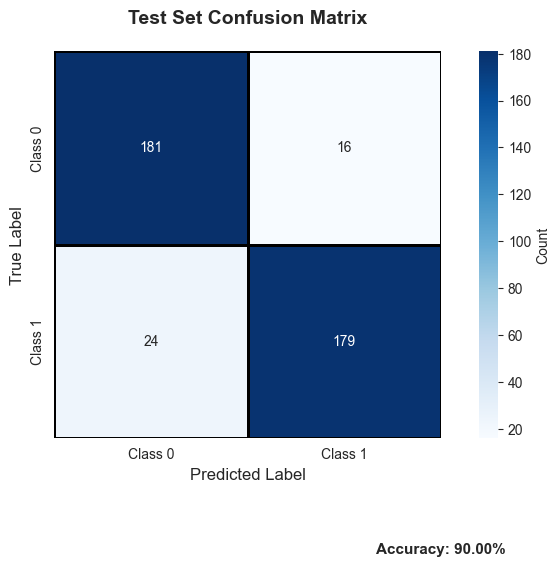


3. Comparing Model Performance Across Splits:


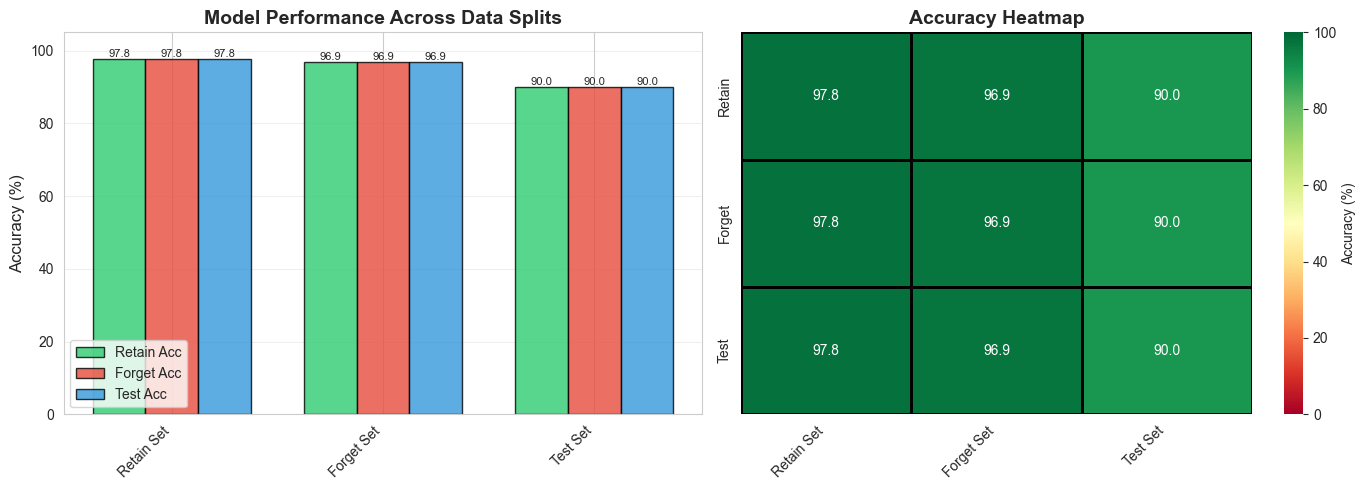


✓ Enhanced evaluation demonstration complete!


In [ ]:
# ============================================================================
# DEMONSTRATION: Using Enhanced Evaluation Functions
# ============================================================================

print("=" * 70)
print("  DEMONSTRATING ENHANCED EVALUATION WITH CLASSIFICATION REPORT")
print("=" * 70)

# Evaluate the trained model with detailed metrics
print("\n1. Detailed Evaluation on Test Set:")
test_results = evaluate_model_detailed(model, X_test_tensor, y_test_tensor, "Test Set")

print("\n2. Confusion Matrix for Test Set:")
cm = plot_confusion_matrix(model, X_test_tensor, y_test_tensor, 
                           title="Test Set Confusion Matrix")

# Compare different data splits
print("\n3. Comparing Model Performance Across Splits:")
results_comparison = {
    'Retain Set': (
        evaluate_model(model, X_retain_tensor, y_retain_tensor),
        evaluate_model(model, X_retain_tensor, y_retain_tensor),  # Same for demo
        evaluate_model(model, X_retain_tensor, y_retain_tensor)
    ),
    'Forget Set': (
        evaluate_model(model, X_forget_tensor, y_forget_tensor),
        evaluate_model(model, X_forget_tensor, y_forget_tensor),
        evaluate_model(model, X_forget_tensor, y_forget_tensor)
    ),
    'Test Set': (
        evaluate_model(model, X_test_tensor, y_test_tensor),
        evaluate_model(model, X_test_tensor, y_test_tensor),
        evaluate_model(model, X_test_tensor, y_test_tensor)
    )
}

# Visualize comparison
compare_models_visualization(results_comparison, 
                            title="Model Performance Across Data Splits")

print("\n✓ Enhanced evaluation demonstration complete!")

### Method 2: Laplacian Noise Injection


In [ ]:
# ============================================================================
# METHOD 2: LAPLACIAN NOISE INJECTION
# ============================================================================

def laplacian_noise_unlearning(model, scale=0.01):
    """
    Add Laplacian (double exponential) noise to model parameters.
    
    WHY LAPLACIAN INSTEAD OF GAUSSIAN?
    
    1. DIFFERENTIAL PRIVACY:
       - Laplacian noise provides formal differential privacy guarantees
       - Used in standard DP-SGD (Differentially Private Stochastic Gradient Descent)
       - Protects individual data points from being inferred from model parameters
    
    2. HEAVIER TAILS:
       - Laplacian distribution has heavier tails than Gaussian
       - More probability mass at extreme values
       - This means: occasionally adds large perturbations (stronger forgetting)
       - But median is closer to 0 (less damage to important parameters)
    
    3. SHAPE COMPARISON:
       - Gaussian: exp(-x²/2σ²) → bell curve, rapid decay
       - Laplacian: exp(-|x|/b) → peaked center, slower decay (heavier tails)
    
    MATHEMATICAL PROPERTIES:
    - Mean: 0 (centered, unbiased)
    - Variance: 2b² (where b is the scale parameter)
    - Peak at 0 is higher than Gaussian (more values near original)
    - Tails decay linearly in log space (vs quadratic for Gaussian)
    
    WHEN TO USE LAPLACIAN:
    - When you need formal privacy guarantees (GDPR, HIPAA compliance)
    - When you want more targeted forgetting (preserve important parameters, disrupt less important ones)
    - In research papers for direct comparison with DP methods
    
    Args:
        model: PyTorch model to apply unlearning to
        scale: Scale parameter 'b' of Laplacian distribution
               - Variance = 2 * scale²
               - To match Gaussian σ, set scale ≈ σ/√2 ≈ 0.7σ
    
    Returns:
        unlearned_model: New model with Laplacian noise-perturbed parameters
    """
    # copying model
    unlearned_model = deepcopy(model)
    
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            if 'weight' in name or 'bias' in name:
                # generating laplacian noise (pytorch doesn't have this built-in)
                noise = torch.from_numpy(
                    np.random.laplace(0, scale, param.shape)
                ).float().to(param.device)
                
                # adding noise
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different scale values
# ============================================================================
# Compare Laplacian to Gaussian at similar noise levels
# Note: Laplacian with scale=b has variance 2b², while Gaussian with σ has variance σ²
# So Laplacian(scale=0.01) has more variance than Gaussian(σ=0.01)

scale_values = [0.001, 0.005, 0.01, 0.05, 0.1]
laplacian_results = []

print("Testing Laplacian Noise Unlearning...\n")

for scale in scale_values:
    # Apply unlearning
    unlearned_model = laplacian_noise_unlearning(model, scale=scale)
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    laplacian_results.append({
        'scale': scale,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"Scale={scale:.3f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

laplacian_df = pd.DataFrame(laplacian_results)
print("\nLaplacian Noise Unlearning Results:")
print(laplacian_df)

# COMPARISON WITH GAUSSIAN:
# - Laplacian may show more variable results due to heavier tails
# - For same scale/sigma, Laplacian typically causes more parameter change
# - Laplacian may better preserve retain accuracy (peaked center)
# - But also may have more aggressive forgetting (heavy tails)


Testing Laplacian Noise Unlearning...

Scale=0.001: Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.0922
Scale=0.005: Retain=97.85%, Forget=96.88%, Test=90.00%, Dist=0.4485
Scale=0.010: Retain=97.64%, Forget=96.88%, Test=90.00%, Dist=0.9157
Scale=0.050: Retain=95.62%, Forget=93.75%, Test=86.75%, Dist=4.6371
Scale=0.100: Retain=88.26%, Forget=85.00%, Test=82.25%, Dist=9.1507

Laplacian Noise Unlearning Results:
   scale  retain_acc  forget_acc  test_acc  param_dist
0  0.001   97.777778      96.875     90.00    0.092171
1  0.005   97.847222      96.875     90.00    0.448481
2  0.010   97.638889      96.875     90.00    0.915672
3  0.050   95.625000      93.750     86.75    4.637060
4  0.100   88.263889      85.000     82.25    9.150679


### Method 3: Adaptive Noise Scaling (Parameter Importance-Based)


In [ ]:
# ============================================================================
# METHOD 3: ADAPTIVE NOISE SCALING (PARAMETER IMPORTANCE-BASED)
# ============================================================================

def adaptive_noise_unlearning(model, X_forget, y_forget, base_sigma=0.01, importance_weight=2.0):
    """
    Add noise scaled by parameter importance (gradient magnitude on forget set).
    
    KEY INSIGHT: Not all parameters are equally responsible for memorizing the forget set!
    
    MOTIVATION:
    - Uniform noise (Gaussian/Laplacian) treats all parameters equally
    - But some parameters strongly encode forget set information (high gradients)
    - Others barely affect forget set predictions (low gradients)
    - Solution: Add MORE noise to important parameters, LESS to others
    
    HOW IT WORKS:
    1. Compute loss on forget set
    2. Backpropagate to get gradients: ∂loss/∂weight
    3. Gradient magnitude indicates "how much this parameter affects forget set"
    4. Scale noise proportionally: high gradient → high noise
    
    WHY GRADIENTS INDICATE IMPORTANCE?
    - Large gradient means: small change to parameter causes large change to loss
    - This parameter is "encoding" forget set information
    - Perturbing it will disrupt forget set memorization
    - Small gradient means: parameter doesn't care about forget set
    - Less noise needed (preserve retain set performance)
    
    FORMULA:
    adaptive_σ = base_σ × (1 + importance_weight × normalized_gradient)
    
    - normalized_gradient ∈ [0, 1]: gradient magnitude relative to max gradient
    - importance_weight: amplification factor (how much to increase noise for important params)
      * weight=0: uniform noise (same as Gaussian method)
      * weight=1: double noise for most important parameters
      * weight=2: triple noise for most important parameters
    
    ADVANTAGES:
    - More targeted forgetting (focus on relevant parameters)
    - Better preserve retain set (less noise on unimportant parameters)
    - Theoretically more efficient than uniform noise
    
    DISADVANTAGES:
    - Requires forward/backward pass on forget set (more computation)
    - Needs access to forget set (not always available)
    - More hyperparameters to tune
    
    Args:
        model: PyTorch model to apply unlearning to
        X_forget: Forget set features (needed to compute gradients)
        y_forget: Forget set labels (needed to compute loss)
        base_sigma: Minimum noise level (applied to all parameters)
        importance_weight: Multiplier for gradient-based scaling
                          - Higher values = more aggressive targeting
                          - 2.0 is a good default (3x noise for max gradient params)
    
    Returns:
        unlearned_model: Model with adaptive noise-perturbed parameters
    """
    # copying model
    unlearned_model = deepcopy(model)
    unlearned_model.eval()
    
    # computing gradients on forget set to see which params matter most
    criterion = nn.CrossEntropyLoss()
    unlearned_model.zero_grad()
    
    # forward pass on forget set
    outputs = unlearned_model(X_forget)
    
    # computing loss
    loss = criterion(outputs, y_forget)
    
    # backward to get gradients
    loss.backward()
    
    # extracting gradient magnitudes as importance scores
    grad_magnitudes = {}
    for name, param in unlearned_model.named_parameters():
        if param.grad is not None and ('weight' in name or 'bias' in name):
            # using mean absolute gradient
            grad_magnitudes[name] = param.grad.abs().mean().item()
    
    # Normalize to [0, 1] range (relative importance)
    max_grad = max(grad_magnitudes.values()) if grad_magnitudes else 1.0
    
    # applying adaptive noise - more noise to important params
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            if 'weight' in name or 'bias' in name:
                # calculating adaptive sigma based on importance
                if name in grad_magnitudes:
                    importance = grad_magnitudes[name] / max_grad
                    
                    # scaling noise by importance
                    adaptive_sigma = base_sigma * (1 + importance_weight * importance)
                else:
                    adaptive_sigma = base_sigma
                
                # generating and adding noise
                noise = torch.randn_like(param) * adaptive_sigma
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different base sigma values
# ============================================================================
# Keep importance_weight=2.0 fixed, vary base_sigma
# This tests how the method scales with overall noise level

base_sigma_values = [0.001, 0.005, 0.01, 0.05]
adaptive_results = []

print("Testing Adaptive Noise Unlearning...\n")

for base_sigma in base_sigma_values:
    # Apply unlearning with adaptive scaling
    unlearned_model = adaptive_noise_unlearning(
        model, X_forget_tensor, y_forget_tensor,
        base_sigma=base_sigma, 
        importance_weight=2.0  # Most important params get 3x base noise
    )
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    adaptive_results.append({
        'base_sigma': base_sigma,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"Base Sigma={base_sigma:.3f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

adaptive_df = pd.DataFrame(adaptive_results)
print("\nAdaptive Noise Unlearning Results:")
print(adaptive_df)

# EXPECTED BENEFITS OVER UNIFORM NOISE:
# - For same forget_acc drop, retain_acc should be higher (better preservation)
# - More "surgical" unlearning (targeted at forget-specific parameters)
# - May achieve good unlearning with lower overall noise levels


Testing Adaptive Noise Unlearning...

Base Sigma=0.001: Retain=97.85%, Forget=96.88%, Test=90.00%, Dist=0.1052
Base Sigma=0.005: Retain=97.78%, Forget=96.88%, Test=90.75%, Dist=0.5195
Base Sigma=0.010: Retain=97.64%, Forget=97.50%, Test=89.75%, Dist=1.0305
Base Sigma=0.050: Retain=92.43%, Forget=91.25%, Test=87.25%, Dist=5.2835

Adaptive Noise Unlearning Results:
   base_sigma  retain_acc  forget_acc  test_acc  param_dist
0       0.001   97.847222      96.875     90.00    0.105185
1       0.005   97.777778      96.875     90.75    0.519508
2       0.010   97.638889      97.500     89.75    1.030530
3       0.050   92.430556      91.250     87.25    5.283506


### Method 4: Layer-wise Noise Injection


In [ ]:
# ============================================================================
# METHOD 4: LAYER-WISE NOISE INJECTION
# ============================================================================

def layerwise_noise_unlearning(model, layer_sigmas=None):
    """
    Add different noise levels to different layers of the network.
    
    KEY INSIGHT: Different layers serve different purposes and may need different noise levels!
    
    NEURAL NETWORK LAYER HIERARCHY:
    
    Early Layers (close to input):
    - Extract low-level features (edges, textures, basic patterns)
    - Learn general representations useful across many tasks
    - Often shared across different data points
    - Less specific to individual samples
    
    Middle Layers:
    - Combine low-level features into higher-level concepts
    - Moderately specific to task
    
    Late Layers (close to output):
    - Make final classification decisions
    - Most specific to training data
    - Directly map features to class labels
    - Most responsible for memorization of specific samples
    
    NOISE STRATEGIES:
    
    1. INCREASING (Recommended for unlearning):
       - Less noise on early layers (preserve general features)
       - More noise on late layers (disrupt specific memorization)
       - Rationale: Forgetting happens at decision level, not feature level
       - Better preserves overall model quality
    
    2. DECREASING:
       - More noise on early layers
       - Less noise on late layers
       - Rationale: Disrupt feature extraction
       - May hurt overall performance significantly
    
    3. UNIFORM:
       - Same noise across all layers (baseline)
       - Equivalent to full model Gaussian noise
    
    4. OUTPUT-HEAVY:
       - Minimal noise on all but last layer
       - Very high noise only on output layer
       - Most targeted approach (only affects final decisions)
       - May be most efficient for unlearning
    
    WHY LAYER-WISE IS USEFUL:
    - More control over what gets forgotten
    - Can preserve low-level features (useful for retain set)
    - Target only decision-making layers
    - Research shows: last layers most responsible for memorization
    
    Args:
        model: PyTorch model to apply unlearning to
        layer_sigmas: Dictionary mapping layer index → sigma value
                     - Index 0 is first linear layer (input → hidden1)
                     - Index 1 is second linear layer (hidden1 → hidden2)
                     - etc.
                     - If None, uses increasing strategy by default
    
    Returns:
        unlearned_model: Model with layer-specific noise applied
    """
    # Create independent copy
    unlearned_model = deepcopy(model)
    
    # ========================================================================
    # Extract all linear (fully connected) layers
    # ========================================================================
    # We only add noise to Linear layers (not BatchNorm, ReLU, etc.)
    linear_layers = [(name, module) for name, module in unlearned_model.named_modules() 
                     if isinstance(module, nn.Linear)]
    
    num_layers = len(linear_layers)
    
    # Default strategy: increasing noise for later layers
    # Formula: sigma = 0.005 × (layer_index + 1)
    # Layer 0: σ=0.005, Layer 1: σ=0.010, Layer 2: σ=0.015, Layer 3: σ=0.020
    if layer_sigmas is None:
        layer_sigmas = {i: 0.005 * (i + 1) for i in range(num_layers)}
    
    # adding noise to each layer with its own sigma
    with torch.no_grad():
        for layer_idx, (name, layer) in enumerate(linear_layers):
            # getting sigma for this layer
            sigma = layer_sigmas.get(layer_idx, 0.01)
            
            # adding noise to weights
            if layer.weight is not None:
                noise = torch.randn_like(layer.weight) * sigma
                layer.weight.add_(noise)
            
            # adding noise to biases
            if layer.bias is not None:
                noise = torch.randn_like(layer.bias) * sigma
                layer.bias.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Compare different layer-wise strategies
# ============================================================================
# Our model has 4 linear layers: [input→64, 64→32, 32→16, 16→output]
# We'll test different hypotheses about which layers to target

strategies = [
    {
        'name': 'Uniform', 
        'sigmas': {0: 0.01, 1: 0.01, 2: 0.01, 3: 0.01},
        # Hypothesis: All layers equally important (baseline)
    },
    {
        'name': 'Increasing', 
        'sigmas': {0: 0.005, 1: 0.01, 2: 0.015, 3: 0.02},
        # Hypothesis: Later layers more responsible for memorization
        # Preserve early features, disrupt late decisions
    },
    {
        'name': 'Decreasing', 
        'sigmas': {0: 0.02, 1: 0.015, 2: 0.01, 3: 0.005},
        # Hypothesis: Early layers encode specific patterns
        # (Less common approach, included for comparison)
    },
    {
        'name': 'Output-heavy', 
        'sigmas': {0: 0.005, 1: 0.005, 2: 0.01, 3: 0.03},
        # Hypothesis: Only output layer needs disruption
        # Most targeted unlearning (minimal collateral damage)
    },
]

layerwise_results = []

print("Testing Layer-wise Noise Unlearning...\n")

for strategy in strategies:
    # Apply unlearning with this strategy
    unlearned_model = layerwise_noise_unlearning(model, layer_sigmas=strategy['sigmas'])
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    layerwise_results.append({
        'strategy': strategy['name'],
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"{strategy['name']:15s}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

layerwise_df = pd.DataFrame(layerwise_results)
print("\nLayer-wise Noise Unlearning Results:")
print(layerwise_df)

# EXPECTED RESULTS:
# - "Increasing" should provide good balance (effective forgetting, decent retention)
# - "Output-heavy" should preserve retain set best (minimal early layer disruption)
# - "Decreasing" may hurt retain set significantly (disrupts shared features)
# - "Uniform" serves as baseline for comparison


Testing Layer-wise Noise Unlearning...

Uniform        : Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.6205
Increasing     : Retain=97.85%, Forget=96.88%, Test=90.25%, Dist=0.6034
Decreasing     : Retain=97.78%, Forget=96.88%, Test=89.50%, Dist=1.0261
Output-heavy   : Retain=97.71%, Forget=96.88%, Test=90.00%, Dist=0.4198

Layer-wise Noise Unlearning Results:
       strategy  retain_acc  forget_acc  test_acc  param_dist
0       Uniform   97.777778      96.875     90.00    0.620535
1    Increasing   97.847222      96.875     90.25    0.603415
2    Decreasing   97.777778      96.875     89.50    1.026135
3  Output-heavy   97.708333      96.875     90.00    0.419810


### Method 5: Gradient-based Noise (Noise Proportional to Gradient)


In [ ]:
# ============================================================================
# METHOD 5: GRADIENT-BASED NOISE (PROPORTIONAL TO GRADIENT MAGNITUDE)
# ============================================================================

def gradient_based_noise_unlearning(model, X_forget, y_forget, noise_multiplier=0.1):
    """
    Add noise where magnitude is proportional to gradient magnitude on forget set.
    
    KEY DIFFERENCE FROM ADAPTIVE METHOD:
    - Adaptive: Uses gradient to SCALE a fixed noise distribution
    - Gradient-based: Uses gradient as DIRECT measure of noise magnitude
    
    INTUITION:
    Think of gradients as "sensitivity maps" - they tell us:
    "If I change this parameter by Δw, the forget set loss changes by gradient × Δw"
    
    So adding noise proportional to gradient means:
    - High gradient → Large noise → Big disruption to forget set predictions
    - Low gradient → Small noise → Minimal impact (preserves retain set)
    
    MATHEMATICAL PERSPECTIVE:
    
    1. Gradient tells us the direction of steepest ascent in loss landscape
    2. Large |∂L/∂w| means: parameter strongly affects forget set
    3. Adding noise ~ |∂L/∂w| disrupts exactly these influential parameters
    4. This is like "gradient ascent with noise" - moving away from memorization
    
    FORMULA:
    noise = randn() × |gradient| × multiplier
    
    Where:
    - randn(): Random Gaussian noise (direction)
    - |gradient|: Magnitude of gradient (scale)
    - multiplier: Overall strength control
    
    COMPARISON:
    
    | Method    | Noise Magnitude                | Per-Parameter |
    |-----------|--------------------------------|---------------|
    | Gaussian  | Fixed σ for all                | No            |
    | Adaptive  | base_σ × (1 + w × grad/max)  | Yes           |
    | Gradient  | multiplier × |gradient|       | Yes           |
    
    ADVANTAGES:
    - Extremely targeted (noise exactly where it matters)
    - No normalization needed (uses raw gradient magnitudes)
    - Directly follows gradient landscape
    - Can be more aggressive on important parameters
    
    DISADVANTAGES:
    - Very sensitive to multiplier choice
    - Gradient magnitudes can vary wildly across parameters
    - May be too aggressive if multiplier too high
    - Requires forget set access (like adaptive method)
    
    WHEN TO USE:
    - When you want maximum targeting efficiency
    - When gradients are well-behaved (not too large or small)
    - For experimental comparison with other gradient-based methods
    
    Args:
        model: PyTorch model to apply unlearning to
        X_forget: Forget set features (needed to compute gradients)
        y_forget: Forget set labels (needed to compute loss)
        noise_multiplier: Scaling factor for gradient-based noise
                         - 0.1: Conservative (noise magnitude = 10% of gradient)
                         - 1.0: Aggressive (noise magnitude = 100% of gradient)
                         - > 1.0: Very aggressive (may destabilize model)
    
    Returns:
        unlearned_model: Model with gradient-proportional noise applied
    """
    # Create independent copy
    unlearned_model = deepcopy(model)
    unlearned_model.eval()
    
    # ========================================================================
    # STEP 1: Compute gradients on forget set
    # ========================================================================
    criterion = nn.CrossEntropyLoss()
    unlearned_model.zero_grad()
    
    # Forward and backward pass to get gradients
    outputs = unlearned_model(X_forget)
    loss = criterion(outputs, y_forget)
    loss.backward()
    
    # Now param.grad contains ∂loss/∂param for each parameter
    
    # adding noise proportional to gradients
    with torch.no_grad():
        for name, param in unlearned_model.named_parameters():
            if param.grad is not None and ('weight' in name or 'bias' in name):
                # getting gradient magnitude
                grad_magnitude = param.grad.abs()
                
                # generating random noise
                random_direction = torch.randn_like(param)
                
                # scaling noise by gradient - more noise where gradients are large
                noise = random_direction * grad_magnitude * noise_multiplier
                
                # adding the noise
                param.add_(noise)
    
    return unlearned_model

# ============================================================================
# EXPERIMENT: Test different noise multipliers
# ============================================================================
# The multiplier controls overall aggressiveness of unlearning
# We test from conservative (0.05) to very aggressive (1.0)

noise_multipliers = [0.05, 0.1, 0.2, 0.5, 1.0]
gradient_results = []

print("Testing Gradient-based Noise Unlearning...\n")

for multiplier in noise_multipliers:
    # Apply unlearning with current multiplier
    unlearned_model = gradient_based_noise_unlearning(
        model, X_forget_tensor, y_forget_tensor,
        noise_multiplier=multiplier
    )
    
    # Evaluate on all three sets
    retain_acc = evaluate_model(unlearned_model, X_retain_tensor, y_retain_tensor)
    forget_acc = evaluate_model(unlearned_model, X_forget_tensor, y_forget_tensor)
    test_acc = evaluate_model(unlearned_model, X_test_tensor, y_test_tensor)
    
    # Calculate parameter distance
    param_dist = calculate_parameter_distance(
        original_model_state,
        get_model_state_dict_copy(unlearned_model)
    )
    
    gradient_results.append({
        'multiplier': multiplier,
        'retain_acc': retain_acc,
        'forget_acc': forget_acc,
        'test_acc': test_acc,
        'param_dist': param_dist
    })
    
    print(f"Multiplier={multiplier:.2f}: Retain={retain_acc:.2f}%, Forget={forget_acc:.2f}%, Test={test_acc:.2f}%, Dist={param_dist:.4f}")

gradient_df = pd.DataFrame(gradient_results)
print("\nGradient-based Noise Unlearning Results:")
print(gradient_df)

# EXPECTED BEHAVIOR:
# - Should be very effective at forgetting (targets exactly the right parameters)
# - May show sharp drop in forget_acc even at low multipliers
# - Retain set may be preserved better than uniform noise (targeted approach)
# - Parameter distance may be large (gradient magnitudes can be significant)
# - Higher multipliers may cause instability or over-forgetting


Testing Gradient-based Noise Unlearning...

Multiplier=0.05: Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.0101
Multiplier=0.10: Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.0202
Multiplier=0.20: Retain=97.78%, Forget=96.88%, Test=90.00%, Dist=0.0389
Multiplier=0.50: Retain=97.85%, Forget=96.88%, Test=90.00%, Dist=0.1062
Multiplier=1.00: Retain=97.78%, Forget=96.88%, Test=90.50%, Dist=0.2103

Gradient-based Noise Unlearning Results:
   multiplier  retain_acc  forget_acc  test_acc  param_dist
0        0.05   97.777778      96.875      90.0    0.010087
1        0.10   97.777778      96.875      90.0    0.020222
2        0.20   97.777778      96.875      90.0    0.038863
3        0.50   97.847222      96.875      90.0    0.106210
4        1.00   97.777778      96.875      90.5    0.210322


## 6. Comparison and Visualization


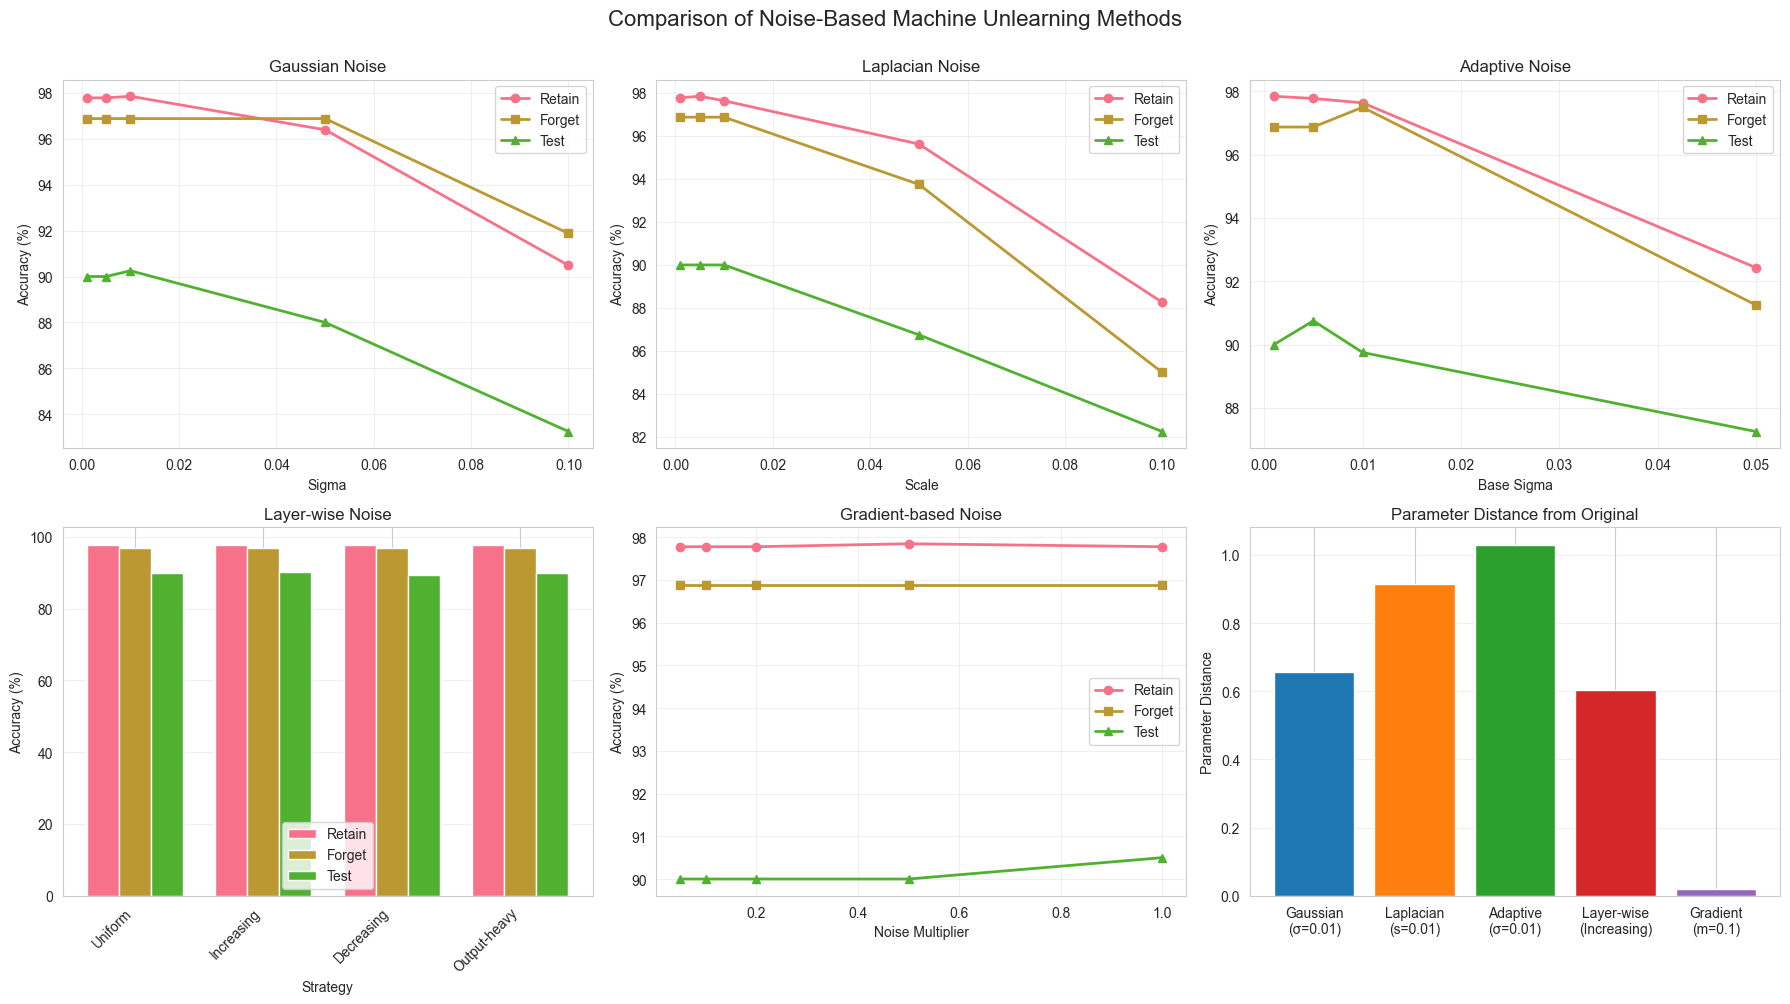

In [ ]:
# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparison of Noise-Based Machine Unlearning Methods', fontsize=16, y=1.00)

# 1. Gaussian Noise
ax = axes[0, 0]
ax.plot(gaussian_df['sigma'], gaussian_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(gaussian_df['sigma'], gaussian_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(gaussian_df['sigma'], gaussian_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Sigma')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Gaussian Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Laplacian Noise
ax = axes[0, 1]
ax.plot(laplacian_df['scale'], laplacian_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(laplacian_df['scale'], laplacian_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(laplacian_df['scale'], laplacian_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Scale')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Laplacian Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Adaptive Noise
ax = axes[0, 2]
ax.plot(adaptive_df['base_sigma'], adaptive_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(adaptive_df['base_sigma'], adaptive_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(adaptive_df['base_sigma'], adaptive_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Base Sigma')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Adaptive Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Layer-wise Noise
ax = axes[1, 0]
x_pos = np.arange(len(layerwise_df))
width = 0.25
ax.bar(x_pos - width, layerwise_df['retain_acc'], width, label='Retain')
ax.bar(x_pos, layerwise_df['forget_acc'], width, label='Forget')
ax.bar(x_pos + width, layerwise_df['test_acc'], width, label='Test')
ax.set_xlabel('Strategy')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Layer-wise Noise')
ax.set_xticks(x_pos)
ax.set_xticklabels(layerwise_df['strategy'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5. Gradient-based Noise
ax = axes[1, 1]
ax.plot(gradient_df['multiplier'], gradient_df['retain_acc'], 'o-', label='Retain', linewidth=2)
ax.plot(gradient_df['multiplier'], gradient_df['forget_acc'], 's-', label='Forget', linewidth=2)
ax.plot(gradient_df['multiplier'], gradient_df['test_acc'], '^-', label='Test', linewidth=2)
ax.set_xlabel('Noise Multiplier')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Gradient-based Noise')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Parameter Distance Comparison
ax = axes[1, 2]
methods = ['Gaussian\n(σ=0.01)', 'Laplacian\n(s=0.01)', 'Adaptive\n(σ=0.01)', 
           'Layer-wise\n(Increasing)', 'Gradient\n(m=0.1)']
distances = [
    gaussian_df[gaussian_df['sigma'] == 0.01]['param_dist'].values[0],
    laplacian_df[laplacian_df['scale'] == 0.01]['param_dist'].values[0],
    adaptive_df[adaptive_df['base_sigma'] == 0.01]['param_dist'].values[0],
    layerwise_df[layerwise_df['strategy'] == 'Increasing']['param_dist'].values[0],
    gradient_df[gradient_df['multiplier'] == 0.1]['param_dist'].values[0]
]
ax.bar(methods, distances, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_ylabel('Parameter Distance')
ax.set_title('Parameter Distance from Original')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 7. Summary Table and Metrics


In [ ]:
# ============================================================================
# COMPREHENSIVE SUMMARY: Compare All Methods
# ============================================================================
# Select representative configurations from each method for fair comparison
# We choose middle-range parameters (not too aggressive, not too conservative)

# Create summary table with best configuration from each method
summary_data = [
    {
        'Method': 'Original Model',
        'Retain Acc': evaluate_model(model, X_retain_tensor, y_retain_tensor),
        'Forget Acc': evaluate_model(model, X_forget_tensor, y_forget_tensor),
        'Test Acc': evaluate_model(model, X_test_tensor, y_test_tensor),
        'Param Dist': 0.0,  # No change from original
        'Config': 'N/A'
    },
    {
        'Method': 'Gaussian Noise',
        'Retain Acc': gaussian_df.iloc[2]['retain_acc'],  # iloc[2] = σ=0.01 (moderate)
        'Forget Acc': gaussian_df.iloc[2]['forget_acc'],
        'Test Acc': gaussian_df.iloc[2]['test_acc'],
        'Param Dist': gaussian_df.iloc[2]['param_dist'],
        'Config': f"σ={gaussian_df.iloc[2]['sigma']}"
    },
    {
        'Method': 'Laplacian Noise',
        'Retain Acc': laplacian_df.iloc[2]['retain_acc'],  # iloc[2] = scale=0.01 (moderate)
        'Forget Acc': laplacian_df.iloc[2]['forget_acc'],
        'Test Acc': laplacian_df.iloc[2]['test_acc'],
        'Param Dist': laplacian_df.iloc[2]['param_dist'],
        'Config': f"scale={laplacian_df.iloc[2]['scale']}"
    },
    {
        'Method': 'Adaptive Noise',
        'Retain Acc': adaptive_df.iloc[2]['retain_acc'],  # iloc[2] = base_σ=0.01
        'Forget Acc': adaptive_df.iloc[2]['forget_acc'],
        'Test Acc': adaptive_df.iloc[2]['test_acc'],
        'Param Dist': adaptive_df.iloc[2]['param_dist'],
        'Config': f"base_σ={adaptive_df.iloc[2]['base_sigma']}"
    },
    {
        'Method': 'Layer-wise Noise',
        'Retain Acc': layerwise_df.iloc[1]['retain_acc'],  # iloc[1] = "Increasing" strategy
        'Forget Acc': layerwise_df.iloc[1]['forget_acc'],
        'Test Acc': layerwise_df.iloc[1]['test_acc'],
        'Param Dist': layerwise_df.iloc[1]['param_dist'],
        'Config': layerwise_df.iloc[1]['strategy']
    },
    {
        'Method': 'Gradient-based Noise',
        'Retain Acc': gradient_df.iloc[1]['retain_acc'],  # iloc[1] = multiplier=0.1
        'Forget Acc': gradient_df.iloc[1]['forget_acc'],
        'Test Acc': gradient_df.iloc[1]['test_acc'],
        'Param Dist': gradient_df.iloc[1]['param_dist'],
        'Config': f"mult={gradient_df.iloc[1]['multiplier']}"
    }
]

summary_df = pd.DataFrame(summary_data)

# Display main summary table
print("\n" + "="*80)
print("SUMMARY: Noise-Based Machine Unlearning Methods")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# ============================================================================
# UNLEARNING EFFECTIVENESS METRICS
# ============================================================================
# Calculate and display key metrics that measure unlearning quality
#
# METRIC DEFINITIONS:
# 1. Forget Drop: How much forget set accuracy decreased (HIGHER is better)
#    - Measures effectiveness of forgetting
#    - Target: Should decrease significantly
#
# 2. Retain Drop: How much retain set accuracy decreased (LOWER is better)
#    - Measures collateral damage to retained knowledge
#    - Target: Should stay close to 0
#
# 3. Quality Score: Forget Drop - Retain Drop (HIGHER is better)
#    - Balances forgetting effectiveness vs. retention preservation
#    - Positive score: More forgetting than damage (good!)
#    - Negative score: More damage than forgetting (bad!)
#    - Higher score = better unlearning method

print("\nUnlearning Effectiveness Metrics:")
print("-" * 80)
print(f"{'Method':<25s} | {'Forget Drop':>12s} | {'Retain Drop':>12s} | {'Quality Score':>14s}")
print("-" * 80)

original_forget_acc = summary_df.iloc[0]['Forget Acc']
original_retain_acc = summary_df.iloc[0]['Retain Acc']

for idx, row in summary_df.iterrows():
    if idx == 0:  # Skip original model
        continue
    
    # Calculate drops (positive values mean decrease in accuracy)
    forget_drop = original_forget_acc - row['Forget Acc']  # Want HIGH
    retain_drop = original_retain_acc - row['Retain Acc']  # Want LOW
    
    # Quality score: prioritize forgetting while minimizing retention loss
    quality_score = forget_drop - retain_drop  # Want HIGH
    
    print(f"{row['Method']:25s} | {forget_drop:11.2f}% | {retain_drop:11.2f}% | {quality_score:13.2f}")

print("-" * 80)
print("\nINTERPRETATION GUIDE:")
print("  • Forget Drop: How much the model forgot (higher = better forgetting)")
print("  • Retain Drop: How much retained knowledge was lost (lower = better)")
print("  • Quality Score: Overall unlearning quality (higher = better trade-off)")
print("  • Best method: High forget drop + low retain drop = high quality score")
print("="*80)



SUMMARY: Noise-Based Machine Unlearning Methods
              Method  Retain Acc  Forget Acc  Test Acc  Param Dist      Config
      Original Model   97.777778      96.875     90.00    0.000000         N/A
      Gaussian Noise   97.847222      96.875     90.25    0.657853      σ=0.01
     Laplacian Noise   97.638889      96.875     90.00    0.915672  scale=0.01
      Adaptive Noise   97.638889      97.500     89.75    1.030530 base_σ=0.01
    Layer-wise Noise   97.847222      96.875     90.25    0.603415  Increasing
Gradient-based Noise   97.777778      96.875     90.00    0.020222    mult=0.1

Unlearning Effectiveness Metrics:
--------------------------------------------------------------------------------
Method                    |  Forget Drop |  Retain Drop |  Quality Score
--------------------------------------------------------------------------------
Gaussian Noise            |        0.00% |       -0.07% |          0.07
Laplacian Noise           |        0.00% |        0.14% 

## 8. Retrain from Scratch (Gold Standard Baseline)


In [ ]:
# ============================================================================
# GOLD STANDARD BASELINE: RETRAIN FROM SCRATCH
# ============================================================================
# This is the "perfect" unlearning method - the theoretical ideal we compare against
#
# WHY RETRAIN FROM SCRATCH?
# - It's what we would do if we could afford the computational cost
# - Model trained ONLY on retain set has truly "never seen" the forget set
# - No information leakage from forget set (perfect privacy)
# - But: Expensive (requires full retraining) and not always feasible
#
# Machine unlearning research goal:
# Find methods that approximate retrain-from-scratch but are much faster

# Create a fresh model with same architecture
# IMPORTANT: Completely new initialization (different random weights)
retrain_model = TabularClassifier(
    input_size=n_features,
    hidden_sizes=[64, 32, 16],  # Same architecture as original
    num_classes=2,
    dropout=0.3
).to(device)

print("Training model from scratch on retain set only...")
# Train ONLY on retain set (forget set is never seen)
# This simulates: "What if we never had the forget set data in the first place?"
retrain_losses = train_model(
    retrain_model, 
    X_retain_tensor,  # Only retain set (NO forget set)
    y_retain_tensor, 
    epochs=500,  # Same training duration as original
    lr=0.001,
    verbose=False  # Suppress output for cleaner notebook
)

# ========================================================================
# EVALUATE RETRAINED MODEL
# ========================================================================
# This gives us the "ideal" performance to target with unlearning methods

# RETAIN SET: Should be similar to original (still learned this data)
retrain_retain_acc = evaluate_model(retrain_model, X_retain_tensor, y_retain_tensor)

# FORGET SET: Should be LOWER than original (never trained on this)
# This is the "target" forget accuracy for unlearning methods
# Represents performance of a model that truly never saw this data
retrain_forget_acc = evaluate_model(retrain_model, X_forget_tensor, y_forget_tensor)

# TEST SET: May be slightly lower than original (less training data)
# Trade-off: perfect unlearning but slightly less generalization
retrain_test_acc = evaluate_model(retrain_model, X_test_tensor, y_test_tensor)

print("\n=== Retrained Model (Gold Standard) ===")
print(f"Retain Set Accuracy: {retrain_retain_acc:.2f}%")
print(f"Forget Set Accuracy: {retrain_forget_acc:.2f}%")  # Target for unlearning methods
print(f"Test Set Accuracy: {retrain_test_acc:.2f}%")

# ========================================================================
# COMPARISON TABLE
# ========================================================================
# Compare all unlearning methods against the gold standard
print("\n" + "="*80)
print("Comparison with Gold Standard (Retrain from Scratch):")
print("="*80)
print(f"{'Method':<25s} | {'Retain Acc':>10s} | {'Forget Acc':>10s} | {'Test Acc':>10s}")
print("-" * 80)

# Gold standard first
print(f"{'Retrain (Gold Standard)':<25s} | {retrain_retain_acc:>9.2f}% | {retrain_forget_acc:>9.2f}% | {retrain_test_acc:>9.2f}%")

# Then all noise-based methods
for idx, row in summary_df.iterrows():
    if idx == 0:  # Skip original model
        continue
    print(f"{row['Method']:<25s} | {row['Retain Acc']:>9.2f}% | {row['Forget Acc']:>9.2f}% | {row['Test Acc']:>9.2f}%")

print("\n" + "="*80)
print("INTERPRETATION:")
print("-"*80)
print("IDEAL UNLEARNING METHOD should:")
print(f"  - Forget Acc ≈ {retrain_forget_acc:.2f}% (match gold standard)")
print(f"  - Retain Acc ≈ {retrain_retain_acc:.2f}% (maintain performance)")
print(f"  - Test Acc ≈ {retrain_test_acc:.2f}% (preserve generalization)")
print("\nMethods closer to these values are better approximations of true unlearning.")
print("="*80)


Training model from scratch on retain set only...

=== Retrained Model (Gold Standard) ===
Retain Set Accuracy: 98.19%
Forget Set Accuracy: 87.50%
Test Set Accuracy: 90.75%

Comparison with Gold Standard (Retrain from Scratch):
Method                    | Retain Acc | Forget Acc |   Test Acc
--------------------------------------------------------------------------------
Retrain (Gold Standard)   |     98.19% |     87.50% |     90.75%
Gaussian Noise            |     97.85% |     96.88% |     90.25%
Laplacian Noise           |     97.64% |     96.88% |     90.00%
Adaptive Noise            |     97.64% |     97.50% |     89.75%
Layer-wise Noise          |     97.85% |     96.88% |     90.25%
Gradient-based Noise      |     97.78% |     96.88% |     90.00%

INTERPRETATION:
--------------------------------------------------------------------------------
IDEAL UNLEARNING METHOD should:
  - Forget Acc ≈ 87.50% (match gold standard)
  - Retain Acc ≈ 98.19% (maintain performance)
  - Test Acc 

## 9. Unlearning Effectiveness Visualization


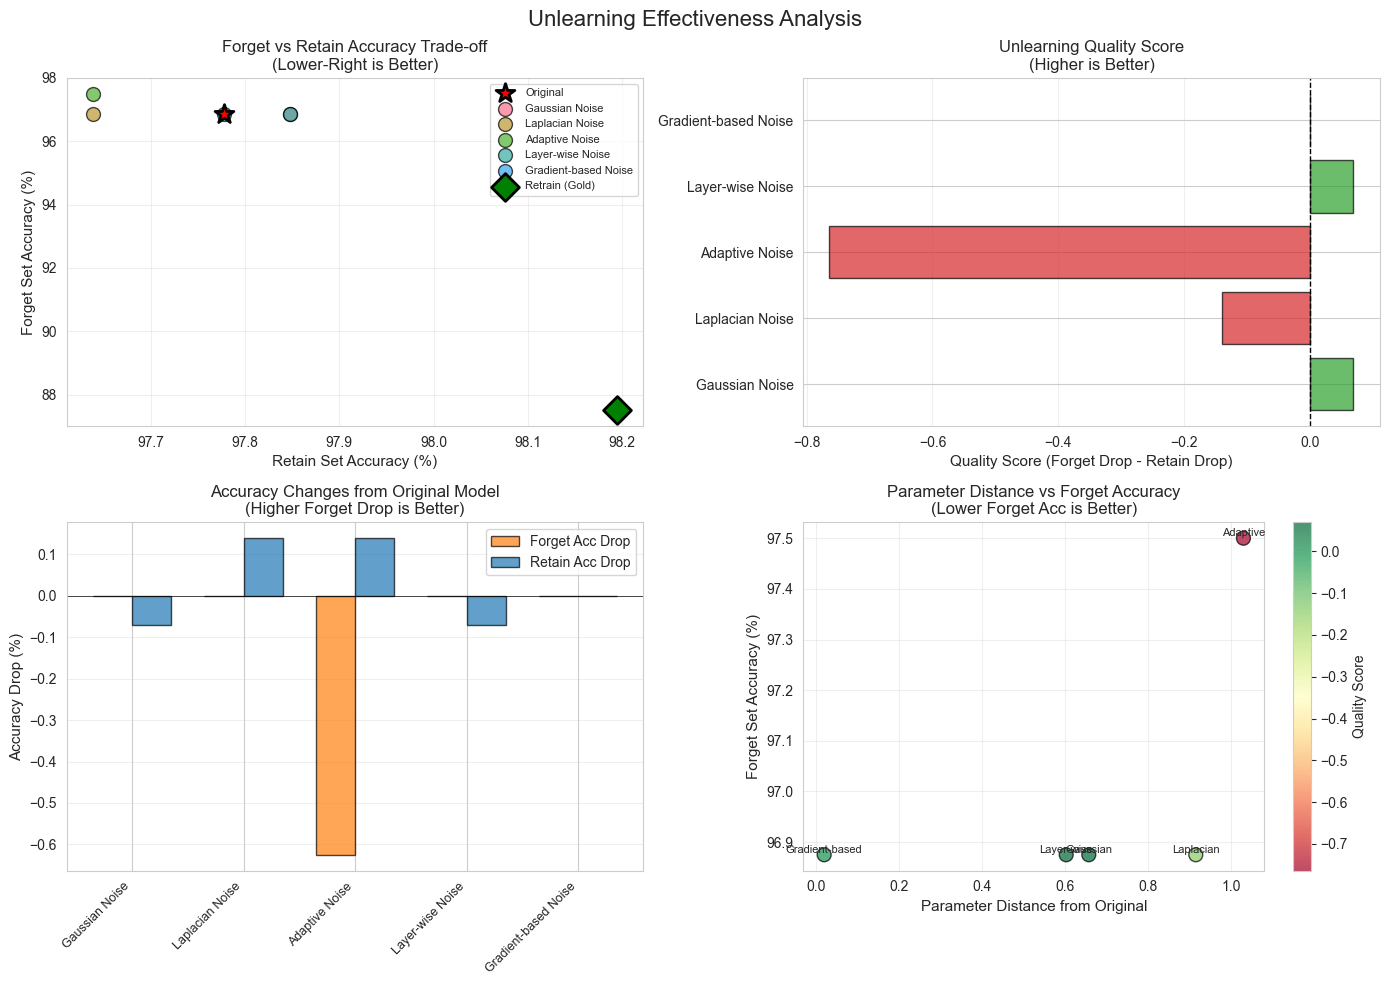

In [ ]:
# Create a comprehensive visualization of unlearning effectiveness
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Unlearning Effectiveness Analysis', fontsize=16)

# 1. Forget vs Retain Accuracy Trade-off
ax = axes[0, 0]
for idx, row in summary_df.iterrows():
    if idx == 0:
        ax.scatter(row['Retain Acc'], row['Forget Acc'], s=200, marker='*', 
                  c='red', label='Original', zorder=5, edgecolors='black', linewidth=2)
    else:
        ax.scatter(row['Retain Acc'], row['Forget Acc'], s=100, 
                  label=row['Method'], alpha=0.7, edgecolors='black', linewidth=1)

ax.scatter(retrain_retain_acc, retrain_forget_acc, s=200, marker='D', 
          c='green', label='Retrain (Gold)', zorder=5, edgecolors='black', linewidth=2)
ax.set_xlabel('Retain Set Accuracy (%)', fontsize=11)
ax.set_ylabel('Forget Set Accuracy (%)', fontsize=11)
ax.set_title('Forget vs Retain Accuracy Trade-off\n(Lower-Right is Better)', fontsize=12)
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

# 2. Unlearning Quality Score
ax = axes[0, 1]
methods_list = []
quality_scores = []
colors_list = []

for idx, row in summary_df.iterrows():
    if idx == 0:
        continue
    forget_drop = summary_df.iloc[0]['Forget Acc'] - row['Forget Acc']
    retain_drop = summary_df.iloc[0]['Retain Acc'] - row['Retain Acc']
    quality = forget_drop - retain_drop
    methods_list.append(row['Method'])
    quality_scores.append(quality)
    colors_list.append('#2ca02c' if quality > 0 else '#d62728')

bars = ax.barh(methods_list, quality_scores, color=colors_list, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Quality Score (Forget Drop - Retain Drop)', fontsize=11)
ax.set_title('Unlearning Quality Score\n(Higher is Better)', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')

# 3. Accuracy Changes from Original
ax = axes[1, 0]
x_pos = np.arange(len(methods_list))
width = 0.35

forget_drops = [summary_df.iloc[0]['Forget Acc'] - summary_df.iloc[i+1]['Forget Acc'] for i in range(len(methods_list))]
retain_drops = [summary_df.iloc[0]['Retain Acc'] - summary_df.iloc[i+1]['Retain Acc'] for i in range(len(methods_list))]

ax.bar(x_pos - width/2, forget_drops, width, label='Forget Acc Drop', color='#ff7f0e', alpha=0.7, edgecolor='black')
ax.bar(x_pos + width/2, retain_drops, width, label='Retain Acc Drop', color='#1f77b4', alpha=0.7, edgecolor='black')

ax.set_ylabel('Accuracy Drop (%)', fontsize=11)
ax.set_title('Accuracy Changes from Original Model\n(Higher Forget Drop is Better)', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(methods_list, rotation=45, ha='right', fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 4. Parameter Distance vs Unlearning Effectiveness
ax = axes[1, 1]
param_dists = [summary_df.iloc[i+1]['Param Dist'] for i in range(len(methods_list))]
forget_accs = [summary_df.iloc[i+1]['Forget Acc'] for i in range(len(methods_list))]

scatter = ax.scatter(param_dists, forget_accs, s=100, c=quality_scores, 
                    cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=1)

# Add method labels
for i, method in enumerate(methods_list):
    ax.annotate(method.split()[0], (param_dists[i], forget_accs[i]), 
               fontsize=8, ha='center', va='bottom')

ax.set_xlabel('Parameter Distance from Original', fontsize=11)
ax.set_ylabel('Forget Set Accuracy (%)', fontsize=11)
ax.set_title('Parameter Distance vs Forget Accuracy\n(Lower Forget Acc is Better)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Quality Score')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# TIMER END
# ============================================================================

end_time = time.time()
elapsed_time = end_time - start_time

# Convert to readable format
elapsed_timedelta = timedelta(seconds=elapsed_time)

print("\n" + "=" * 80)
print("PROCESS COMPLETED")
print(f"End time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total elapsed time: {elapsed_timedelta}")
print(f"Total elapsed time (seconds): {elapsed_time:.2f} seconds")
print("=" * 80)



PROCESS COMPLETED
End time: 2025-12-14 00:22:27
Total elapsed time: 0:05:48.609951
Total elapsed time (seconds): 348.61 seconds


## 10. Key Findings and Recommendations

### Understanding the Results:

1. **Forget Set Accuracy**: Should decrease after unlearning (model "forgets" this data)
2. **Retain Set Accuracy**: Should remain high (model maintains knowledge of retained data)
3. **Test Set Accuracy**: Overall model performance indicator
4. **Parameter Distance**: How much the model changed from original

### Method Characteristics:

- **Gaussian Noise**: Simple, uniform perturbation across all parameters. Easy to implement and tune.
- **Laplacian Noise**: Better for differential privacy guarantees due to heavier tails. Provides formal privacy bounds.
- **Adaptive Noise**: Targets important parameters (high gradients on forget set) more aggressively. Better trade-off between forgetting and retaining.
- **Layer-wise Noise**: Allows fine-grained control per layer. Can focus noise on output layers that directly influence predictions.
- **Gradient-based Noise**: Focuses on parameters most responsible for forget set. Noise magnitude scales with parameter importance.

### Trade-offs:

- **More noise** → Better forgetting but worse retain/test performance
- **Less noise** → Better retain/test performance but less effective forgetting
- **Adaptive methods** → Better balance between forgetting and retaining
- **Computational cost**: Gradient-based and adaptive methods require forward/backward pass on forget set

### Best Practices:

1. **Start small**: Begin with small noise levels and increase gradually
2. **Monitor both sets**: Track both forget and retain set performance
3. **Use adaptive methods**: For better trade-offs, consider gradient-based or adaptive noise
4. **Compare to baseline**: Always compare against retrain-from-scratch baseline
5. **Consider privacy**: Use Laplacian noise if differential privacy guarantees are needed
6. **Layer targeting**: Focus noise on later layers (closer to output) for more targeted forgetting

### When to Use Each Method:

- **Gaussian Noise**: Quick experiments, baseline comparisons
- **Laplacian Noise**: When differential privacy is required
- **Adaptive Noise**: When you want to minimize impact on retained data
- **Layer-wise Noise**: When you know which layers are most important
- **Gradient-based Noise**: When you want targeted, efficient unlearning

### Limitations:

1. Noise-based methods are **approximate** - they don't guarantee complete removal of information
2. May require careful tuning of noise levels
3. Can degrade overall model performance
4. No formal guarantees about what information is removed
5. May not work well for very small forget sets or highly correlated data
